<a href="https://colab.research.google.com/github/Location-Artistry/GEO-DEV-NOTEBOOKS/blob/main/AirspaceDataWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIRSPACE LINK DATA PROCESSING
Initial Data Exploration and Visualizations using ObservableHQ and Leafmap python mapping interface.     
Loading in data from various sources as GeoJSON and pulled in as GeoDataframe via GeoPandas. GeoDataframe allows any operations that can be performed on a standard pandas dataframe, and is familiar to most Data Scientists.   
The spatial data layers will then be clipped to the City of Detroit Boundary, and loaded as a ArcGIS featureSet, which will allow uploading as a Feature Service on ArcGIS Online via ArcGIS Python API.     


In [ ]:
# GDAL/geoPandas libraries
!apt install gdal-bin python-gdal python3-gdal
!apt install python3-rtree
!pip install pygeos 
!pip install git+git://github.com/geopandas/geopandas.git
import geopandas as gpd
import ogr

# ArcGIS Python API libraries 
!pip install arcgis
from arcgis.gis import GIS, Item
from arcgis.features import FeatureLayerCollection
from arcgis.mapping import WebMap
from arcgis.features import FeatureLayer
from arcgis.features import GeoAccessor, GeoSeriesAccessor

# bmi-arcgis-restapi base for agol Class library 
!pip install bmi-arcgis-restapi
import restapi

# additional imports
import datetime as dt
import getpass
import pandas as pd
import time
import matplotlib.pyplot as plt 
import os

!pip install contextily
import contextily as ctx

## Custom ArcGIS Python API Library
### Primary new Class Object: agol
Sourced from my github GEO-DEV Notebook: [DASHBOARD_UPDATE_WATER_2021.ipynb](https://github.com/Location-Artistry/GEO-DEV-NOTEBOOKS/blob/main/DASHBOARD_UPDATE_WATER_2021.ipynb)


In [ ]:
# Create new class from ArcGIS Python API functions
class agol:
  # -init- function, get user credentials to access GIS object, new Class = agol
  def __init__(self):
    userID = input(f'ArcGIS Online USER ID: ')
    pwd = getpass.getpass('PASSWORD: ')
    try:  
      self.gis = GIS("https://www.arcgis.com", userID, pwd)
      display(f'SUCCESS - CONNECTED TO: {self.gis.users.me.username} ACCOUNT as <gis>')
      display(self.gis)
    except:
        display(f'ERROR DID NOT CONNECT TO: {userID}')
# get list of all owner AGOL items, print list with title, id, type, and categories
  def getContent(self):
    try:
      my_content = self.gis.content.search(query="owner:" + self.gis.users.me.username, item_type="", max_items=500)
      for x in my_content:
        strMod = str(x.modified)
        stampInt = int(strMod[0:10])
        print(f'{x.title} - {x.id} - {x.type} - {x.categories} - {dt.datetime.fromtimestamp(stampInt)}')
      return my_content
    except:
      print('ERROR could not get user content')
# Clone item using id of item passed to function
  def cloneItem(self, gis2, cloneID):    
    try:
      itemToClone, cloneList = self.gis.content.get(cloneID), []
      cloneList.append(itemToClone)
      print('Cloning:' + itemToClone.title + ' - ' + itemToClone.id + ' -',itemToClone.type)
      cloneResult = gis2.gis.content.clone_items(cloneList)
      print(f'Cloned Item: {cloneResult}')
      #return clonedItem
    except:
      print('ERROR Could Not Clone')
# updated searchByKeywords, returns LIST of items 8-14-2020
  def search(self, keyWords, maxItems, iType = ''):
    try:
        search = self.gis.content.search(query=f'{keyWords}', item_type=iType, max_items=maxItems)
        for x, z in enumerate(search):
          strMod = str(z.modified)
          stampInt = int(strMod[0:10])
          print(f'{x} - {z.title} - {z.id} - {z.type} - {z.categories} - {dt.datetime.fromtimestamp(stampInt)}')
        return search
    except:
        print('ERROR Search not Successful')
# find item by keywords and display visual card
  def searchViz(self, keyWords):
    try:
        search = self.gis.content.search(query=f'{keyWords}', item_type='', max_items=50)
        for z in search:
            print(f'title: {z.title} - itemID: {z.id} - type: {z.type}')
            display(z)
    except:
        print('ERROR Search not Successful')
# return all keys and values for item when passed itemID string
  def itemInfo(self, id):
    try:
      getInfo = self.gis.content.get(id)
      for key, value in getInfo.items():
        display(f'{key}: {value}')
    except:
      display('ERROR GET Keys/Values not Successful')    
# takes itemID and gets and returns layerObject if exist, otherwise 'no layers found'
  def getLayers(self, id):
    try:
      feature = self.gis.content.get(id)
      featLay = feature.layers
      for z, x in enumerate(featLay):
        display(f'Layer {z}: {x}')
        return featLay
    except:
        display('no layers found')
# supply feature layer itemID, and the layer number to display table head
# Needs work, displays Feature Layer, not related table 
  def getLayerTable(self, id, layNum):
    try:
      layOut = self.getLayers(id)
      layQuery = layOut[layNum].query()
      display(layQuery.sdf.head())
    except:
      print('ERROR no Tables Found')
# delete item by itemID
  def deleteItem(self, id):
    delItem = self.gis.content.get(id)
    display(delItem)
    delQuest = input(f'Are you sure you want to delete: {delItem.title}')
    try:
      if delQuest.upper() == 'YES':
        display(f'DELETING: {delItem.title}')
        delItem.delete()
      else:
        display(f'NOT DELETING: {delItem.title}')
    except:
        display(f'ERROR failed to DELETE: {delItem.title}')
# create new agolItem class
  def getItem(self, id):
    try:
      item = agolItem(self, id)
      return item
    except:
        display(f'ERROR failed to GET item ID: {id}')

# Function to update attributes in a Feature Layer based on related table values
  def updateLayerFromTable(self, ref):
    # Search for Feature Layer to be updated
    keyWords = input(f'Item Search Query: ') or ''
    iType = input(f'AGOL Item Type: ') or ''
    search = self.search(keyWords, 10,iType)
    ind = int(input(f'Search Item Index: ')) or 0
    # create item as target for update operation
    item = self.getItem(search[ind].id)
    # agol defined functions to get table and layer from the Feature Service
    table = item.getTable()
    layer = item.getLayer()
    # Create FeatureSets from the target layers and tables
    tableFeat = table.table.query()
    layerFeat = layer.layer.query()
    # find the primary key to match layer and table
    for i, field in enumerate(layerFeat.fields):
      print(f'{i} - {field["name"]}')
    ind = int(input(f'PRIMARY MATCH KEY INDEX: ')) or 0
    pKey = layerFeat.fields[ind]["name"]
    # find the target field name
    for i, field in enumerate(layerFeat.fields):
      print(f'{i} - {field["name"]}')
    ind = int(input(f'Layer Target Field Index: ')) or 0
    layAtt = layerFeat.fields[ind]["name"]
    # set target attribute to zero
    for lFeat in layerFeat:
      lFeat.set_value(layAtt, 0)
    edits = layer.layer.edit_features(updates=layerFeat)
    # find the table source field name
    for i, field in enumerate(tableFeat.fields):
      print(f'{i} - {field["name"]}')
    ind = int(input(f'Table Source Field Index: ')) or 0
    tabAtt = tableFeat.fields[ind]["name"]
    # final portion of function
    for tFeat in tableFeat:
    # test for null features
      if (tFeat.attributes['WATER_TEMP']):
        # loop through all layer features to find match with pKey
        for lFeat in layerFeat:
          if tFeat.attributes[pKey] == lFeat.attributes[pKey]:
            print(f'{tFeat.attributes[pKey]} matches {lFeat.attributes[pKey]} value {tFeat.attributes[tabAtt]}')
            for x,val in enumerate(ref, start=1):
              if tFeat.attributes[tabAtt] < val:
                print(f'found value {x}')
                lFeat.set_value(layAtt, x)
                break
    # Now update target layer with updated FeatureSet using edit_features()            
    edits = layer.layer.edit_features(updates=layerFeat)
    # Count edited features, currently counting all features
    for i, edit in enumerate(edits['updateResults'],start=1):
      pass
    print(f'updated {layer.layer.properties.name} with {i} edits')

class agolItem:
# -init- function - create new agol item from agol CLASS and item.id
  def __init__(self,agol,id):
    try:  
      self.item =  agol.gis.content.get(id)
      display(self.item)
    except:
        display(f'ERROR failed to GET item ID: {id}')
  def info(self):
    try:
      keys, infoList = ['id', 'description', 'extent', 'spatialReference', 'url', 'owner', 'layers', 'tables'], []
      for i, z in enumerate(keys):
        infoList.append(self.item[z])
        display(f'{i} - {z} - {self.item[z]}')
      return infoList
    except:
      display(f'FAILED to get infoList for {self.item.title}')
# -init function - get layer from item create new agolLayer Class
  def getLayer(self):
    try:
      for i, lyr in enumerate(self.item.layers):
        display(f'{i} - {lyr.properties.name}')
      time.sleep(1)
      ind = int(input('Select index of Layer: '))
      url = self.item.url
      layer = agolLayer(url, ind)
      return layer
    except:
      display(f'Could not Get Layers for: {self.ags.url}')
  def getTable(self):
    try:
      for i, tab in enumerate(self.item.tables):
        display(f'{i} - {tab.properties.name}')
      time.sleep(1)
      # Quick fix to get proper id index for table instead of related layer
      ind = int(input('Select index of Table: '))  + 1
      url = self.item.url
      table = agolTable(url, ind)
      return table
    except:
      display(f'Could not Get Tables for: {self.ags.url}')
             
class agolLayer:
# -init function - get layer from item create new agolLayer Class 
  def __init__(self, url, ind):
    try:  
      layUrl = (f'{url}/{ind}')
      self.layer = FeatureLayer(layUrl)
    except:
        display(f'ERROR failed to GET Layer: {ind}')
  def layerQuery(self):
    try:
      baseURL = self.layer.url
      SQL = input(f'SQL query(ENTER for ALL): ') or '1=1'
      fields = input(f'Fields(ENTER for ALL)? ') or '*'
      url = (f'{baseURL}/query?f=geojson&where={SQL}&outFields={fields}')
      gdf = gpd.read_file(url)
      return gdf
    except:
      display(f'Query unsuccessful for: {self.item.title}')

class agolTable:
# -init function - get layer from item create new agolLayer Class 
  def __init__(self, url, ind):
    try:  
      tabUrl = (f'{url}/{ind}')
      self.table = FeatureLayer(tabUrl)
    except:
        display(f'ERROR failed to GET Table: {ind}')
  def tableQuery(self):
    try:
      baseURL = self.table.url
      SQL = input(f'SQL query(ENTER for ALL): ') or '1=1'
      fields = input(f'Fields(ENTER for ALL)? ') or '*'
      url = (f'{baseURL}/query?f=geojson&where={SQL}&outFields={fields}')
      gdf = gpd.read_file(url)
      return gdf
    except:
      display(f'Query unsuccessful for: {self.item.title}')

## Custom ArcGIS REST Server Data Explorer Library
### Primary new Class Object: mapServer
Sourced from my github GEO-DEV Notebook: [ArcREST_EXP_MAIN.ipynb](https://github.com/Location-Artistry/GEO-DEV-NOTEBOOKS/blob/main/ArcREST_EXP_MAIN.ipynb)


In [ ]:
# Class creates a <-mapServer object-> based on restapi.ArcServer from bmi-arcgis-restapi library
class mapServer:
# -init- function, ArcServer object as self.ags, server endpoint as self.url
  def __init__(self, url):
    try:
      creds = input(f'Credentials Needed (YES/NO)? ')
      if creds.upper() == 'YES':          
        id = input(f'ArcGIS Online USER ID: ')
        pwd = getpass.getpass('PASSWORD: ')
        self.ags = restapi.ArcServer(url, id, pwd)
      else:
        self.ags = restapi.ArcServer(url)
      self.url = url
      display('MAPSERVER OBJECT CREATED', self.ags)
    except:
      display(f'FAILED TO CREATE MAPSERVER')
# -getServices- displays and returns a list of all ArcGIS services
  def getServices(self):
    for i, service in enumerate(self.ags.services):
      display(f'{i} - Service Name: {service.name} -  Service Type: {service.type}')
    return self.ags.services 
# -getFolders- displays and returns list of all folders
  def getFolders(self):
    try:
      for i, folder in enumerate(self.ags.folders):
        display(f'{i} - Folder: {folder}') 
      return self.ags.folders
    except:
      return 0
# -getNestedServ- gets a mapServer's nested services
  def getNestedServices(self):
    for i, folder in enumerate(self.ags.folders):
      display(f'{i} - Folder: {folder}')
      ags = restapi.ArcServer(f'{self.ags.url}/{folder}')
      for z, service in enumerate(ags.services):
        display(f'   {z} - Service Name: {service.name} -  Service Type: {service.type}')
# -getAttr- get atrributes and show values for non-function methods of for MapServer Object
  def getAttr(self):
    for attribute in dir(self.ags):
      display(f'Attribute Names: {attribute} - {self.ags[attribute]}')
# -listAttr- list all attrbutes of MapServer Object
  def listAttr(self):
    return dir(self.ags)
# -getSubService- returns a arcService object within specified mapServer
  def getSubService(self, rootServer=0):
    folders = self.getFolders()
    services = self.getServices()
    display(f'{self.url} -  ')
    if not folders:
      fID = int(input(f'Select index of subservice: '))
      url = services[fID].name
      try:
        subService = self.getService(url)
        return subService
      except:
        url = (f'{self.url}/{url}/FeatureServer')
        # working here
        subService = arcService(self, url)
        return subService
    else:
      fID = int(input(f'Select index of subservice folder: '))
      serviceURL = (f'{self.url}/{folders[fID]}')
      subFolder = mapServer(serviceURL)
      subServices = subFolder.getServices()
      fID = int(input(f'Select index of subservice: '))
      serviceName = subServices[fID].name
      display(self.url, serviceName)
      subService = arcService(self, serviceName)
      return subService

# Class creates a <-arcService object-> based on ags.getService from bmi-arcgis-restapi library
class arcService:
# -init- create arcService from mapServer Class  
  def __init__(self, server, servName): 
    try:
      self.ags = server.ags.getService(servName)
      self.url = self.ags.url
      display(f'ARCSERVICE OBJECT CREATED - {self.ags.url}')  
    except:
      self.ags = restapi.MapService(servName)
      self.url = self.ags.url
      display(f'ARCSERVICE OBJECT CREATED - {self.ags.url}') 
  def getAttr(self):
    try:
      for attribute in dir(self.ags):
        display(f'Attribute Names: {attribute} - {self.ags[attribute]}')
    except:
      display(f'Could not get Attributes for: {self.ags.url}')
  def listAttr(self):
    try:
      return dir(self.ags)
    except:
      display(f'Could not get List Attributes for: {self.ags.url}')
  def desc(self):
    try:
      return self.ags.description
    except:
      display(f'Could not get Description for: {self.ags.url}')
  def spatialRef(self):
    try:
      return self.ags.spatialReference
    except:
      display(f'Could not get spatialReference for: {self.ags.url}')
  def units(self):
    try:
      return self.ags.units
    except:
      display(f'Could not get Units for: {self.ags.url}')
  def layers(self):
    try:
      return self.ags.list_layers()
    except:
      display(f'Could not list Layers for: {self.ags.url}')
  def tables(self):
    try:
      return self.ags.list_tables()
    except:
      display(f'Could not get Tables for: {self.ags.url}')
# -getLayer- returns a mapLayer from arcService Class
  def getLayer(self):
    try: 
      for i, lay in enumerate(self.ags.layers):
        display(f'{i} - {lay.name}')
      layers = self.layers()
      # small change here separate two lines of code for input ***
      time.sleep(1)
      fID = int(input('Select index of Layer: '))
      layerObj = mapLayer(self, layers[fID])
      return layerObj
    except:
      display(f'Could not Get Layers for: {self.ags.url}')
# -getTable- returns table object from arcService Class  
  def getTable(self):
    try:
      tableList = self.tables()
      for i, lay in enumerate(tableList):
        display(f'{i} - {tableList[i]}')
      time.sleep(1)
      fID = int(input(f'Select index of Table: '))      
      #table = self.ags.table(tableList[fID])
      tableID = tableList[fID]
      table = mapTable(self, tableID)
      return table
    except:
      display(f'Not able to return table for: {self.ags.url}')

# Class creates a <-Layer object-> based on ags.layer from bmi-arcgis-restapi library
class mapLayer:
  def __init__(self, service, lyrName): 
    try:
      self.lyr = service.ags.layer(lyrName)
      display(f'LAYER CREATED - {self.lyr.name} - id: {self.lyr.id} - url: {self.lyr.url}')
    except:
      display(f'COULD NOT CREATE mapLayer')
  def getInfo(self):
    try:
      display(f'{self.lyr.name} - capabilities: {self.lyr.capabilities} - query formats: {self.lyr.supportedQueryFormats} - count: {self.lyr.getCount()}')
    except:
      display(f'Could not get Info for: {self.lyr.name}')
  def getFields(self):
    try:
      return self.lyr.list_fields()
    except:
      display(f'Could not get Fields for: {self.lyr.name}')
  def getSubLayers(self):
    try:
      return self.lyr.subLayers
    except:
      display(f'{self.lyr.name} does not have any SubLayers')
# -layerQuery- prompts user for SQL query and fields, returns geoDataframe object which has access to all pandas/geoPandas methods
  def layerQuery (self):
    try:
      baseURL = self.lyr.url
      SQL = input(f'SQL query(ENTER for ALL): ') or '1=1'
      fields = input(f'Fields(ENTER for ALL)? ') or '*'
      RESTurl = (f'{baseURL}/query?f=geojson&where={SQL}&outFields={fields}')
      gdf = gpd.read_file(RESTurl)
      return gdf
    except:
      display(f'Query unsuccessful for: {self.lyr.name}')

# Class creates a <-mapTable object-> based on ags.layer from bmi-arcgis-restapi library
class mapTable:
  def __init__(self, service, id): 
    try:
      self.table = service.ags.table(id)
      #self.lyr = service.ags.layer(lyrName)
      display(f'TABLE CREATED - {self.table.name} - id: {self.table.id} - url: {self.table.url}')
    except:
      display(f'COULD NOT CREATE mapTable')
  def getInfo(self):
    try:
      display(f'{self.table.name} - capabilities: {self.table.capabilities} - query formats: {self.table.supportedQueryFormats} - count: {self.table.getCount()}')
    except:
      display(f'Could not get Info for: {self.table.name}')
  def getFields(self):
    try:
      return self.table.list_fields()
    except:
      display(f'Could not get Fields for: {self.table.name}')
  def getSubLayers(self):
    try:
      return self.table.subLayers
    except:
      display(f'{self.table.name} does not have any SubTables')
# -layerQuery- prompts user for SQL query and fields, returns geoDataframe object which has access to all pandas/geoPandas methods
  def layerQuery (self):
    try:
      baseURL = self.table.url
      SQL = input(f'SQL query(ENTER for ALL): ') or '1=1'
      fields = input(f'Fields(ENTER for ALL)? ') or '*'
      RESTurl = (f'{baseURL}/query?f=geojson&where={SQL}&outFields={fields}')
      gdf = gpd.read_file(RESTurl)
      return gdf
    except:
      display(f'Query unsuccessful for: {self.table.name}')

## Detroit Open Data Portal
### ArcGIS Rest Server Data Exploration

In [ ]:
# ArcREST endpoint for Detroit Open Data
restURL = 'https://services2.arcgis.com/qvkbeam7Wirps6zC/ArcGIS/rest/services'
gisServer = mapServer(restURL)

# Select GIS service by number
gisService = gisServer.getSubService()

# Select layer fro
gisLayer = gisService
gisLayer.getInfo()

# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

In [ ]:
# ArcREST endpoint for Detroit Open Data
restURL = 'https://services2.arcgis.com/qvkbeam7Wirps6zC/ArcGIS/rest/services'
gisServer = mapServer(restURL)

Credentials Needed (YES/NO)? NO


'MAPSERVER OBJECT CREATED'

<ArcServer: "services2.arcgis.com" ("qvkbeam7Wirps6zC")>

In [ ]:
# Select GIS service by number
gisService = gisServer.getSubService()

In [ ]:
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()

'0 - schools'

Select index of Layer: 0


'LAYER CREATED - schools - id: 0 - url: https://services2.arcgis.com/qvkbeam7Wirps6zC/ArcGIS/rest/services/Schools2017/FeatureServer/0'

'schools - capabilities: Query - query formats: JSON, geoJSON, PBF - count: 0'

In [ ]:
# query layer in generate GeoDataframe
#gdf = gisLayer.layerQuery()
gdf.head()

,objectid,bcode,bname,isdcode,isdname,dcode,dname,entity_type,entity_county,chartering_agency_code,chartering_agency__authorizer_,charter_management_organization,entity_authorized_grades,entity_actual_grades,address,city,state,zip,elementary_student_count__k_5_,middle_student_count__6_8_,high_school_student_count__9_12,elementary,middle,high,xcoord,ycoord,created_user,created_date,last_edited_user,last_edited_date,geometry
0,1,4,Henderson Academy,82,Wayne RESA,82015,Detroit Public Schools Community District,LEA School,Wayne,NaN,None,None,"KG,1,2,3,4,5,6,7,8","KG,1,2,3,4,5,6,7,8",16101 West Chicago St,Detroit,MI,48228,488,238,0,1,1,0,-83.26549,42.36426,SlusarskiD_detroitmi,1516974111167,SlusarskiD_detroitmi,1516974111167,POINT (-83.26549 42.36426)
1,2,5,"Holmes, A.L. Elementary-Middle School",82,Wayne RESA,82015,Detroit Public Schools Community District,LEA School,Wayne,NaN,None,None,"KG,1,2,3,4,5,6,7,8","KG,1,2,3,4,5,6,7,8",8950 Crane St,Detroit,MI,48213,329,108,0,1,1,0,-83.01441,42.39480,SlusarskiD_detroitmi,1516974111167,SlusarskiD_detroitmi,1516974111167,POINT (-83.01441 42.39480)
2,3,18,Medicine and Community Health Academy at Cody,82,Wayne RESA,82015,Detroit Public Schools Community District,LEA School,Wayne,NaN,None,None,"9,10,11,12","9,10,11,12",18445 Cathedral St,Detroit,MI,48228,0,0,387,0,0,1,-83.22077,42.36126,SlusarskiD_detroitmi,1516974111167,SlusarskiD_detroitmi,1516974111167,POINT (-83.22102 42.36075)
3,4,22,Detroit Institute of Technology at Cody,82,Wayne RESA,82015,Detroit Public Schools Community District,LEA School,Wayne,NaN,None,None,"9,10,11,12","9,10,11,12",18445 Cathedral St,Detroit,MI,48228,0,0,260,0,0,1,-83.22077,42.36126,SlusarskiD_detroitmi,1516974111167,SlusarskiD_detroitmi,1516974111167,POINT (-83.22086 42.36066)
4,5,26,Cody Academy of Public Leadership,82,Wayne RESA,82015,Detroit Public Schools Community District,LEA School,Wayne,NaN,None,None,"9,10,11,12","9,10,11,12",18445 Cathedral St,Detroit,MI,48228,0,0,248,0,0,1,-83.22077,42.36126,SlusarskiD_detroitmi,1516974111167,SlusarskiD_detroitmi,1516974111167,POINT (-83.22177 42.36079)


In [ ]:
info = gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 53 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   FID         546 non-null    int64   
 1   ObjectId    546 non-null    int64   
 2   EntityCode  546 non-null    object  
 3   EntityOffi  546 non-null    object  
 4   AgreementN  546 non-null    object  
 5   EntityType  546 non-null    int64   
 6   EntityTy_1  546 non-null    object  
 7   EntityTy_2  546 non-null    int64   
 8   EntityTy_3  546 non-null    object  
 9   EntityTy_4  546 non-null    int64   
 10  EntityTy_5  546 non-null    object  
 11  EntityCoun  546 non-null    int64   
 12  EntityCo_1  546 non-null    object  
 13  EntityChar  546 non-null    object  
 14  EntityCh_1  546 non-null    object  
 15  EntityGeog  546 non-null    int64   
 16  EntityGe_1  546 non-null    object  
 17  EntityNCES  546 non-null    object  
 18  EntityLoca  546 non-null    object  
 19  

In [ ]:
# get gdf columns as a list = col
col = gdf.columns
for i, c in enumerate(col):
  print(f'{i} = {c}')

In [ ]:
# List of unique school names
unique = gdf[col[2]].unique()
display(f'Unique entries for {col[2]}: {len(unique)}')
# print list of unique entries
for i, u in enumerate(unique):
  print(f'{i} = {u}')
# print(unique)

In [ ]:
# count unique values for grades in each school
# There are 70 schools with KG,1,2,3,4,5,6,7,8 
counts = gdf[col[13]].value_counts()
seriesBins = len(counts)

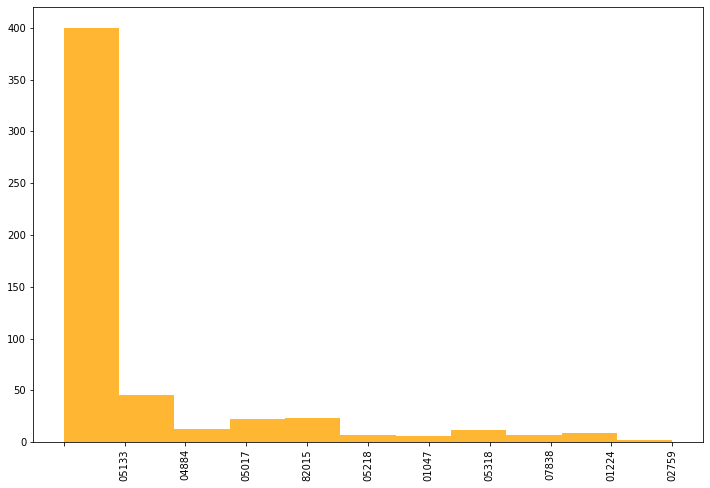

In [ ]:
# histogram of 
gdf[col[13]].hist(alpha=0.8, figsize=(12,8), xrot=90, grid=False, color=['orange'], bins=seriesBins);

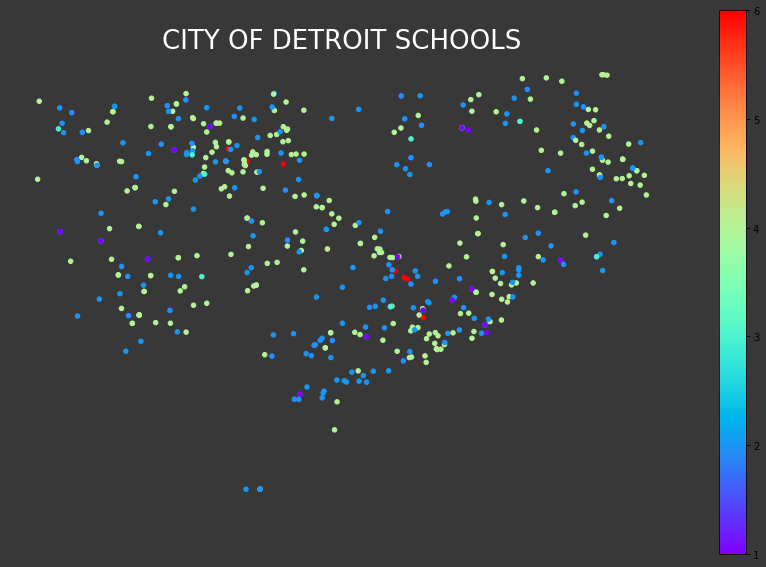

In [ ]:
fig, ax = plt.subplots(figsize=(15,10), facecolor='#383838')
gdf.plot(ax=ax, markersize=20, column = col[7], legend='true', cmap='rainbow')
plt.title("CITY OF DETROIT SCHOOLS", fontsize=26, color='white')
ax.set_axis_off()
plt.show();

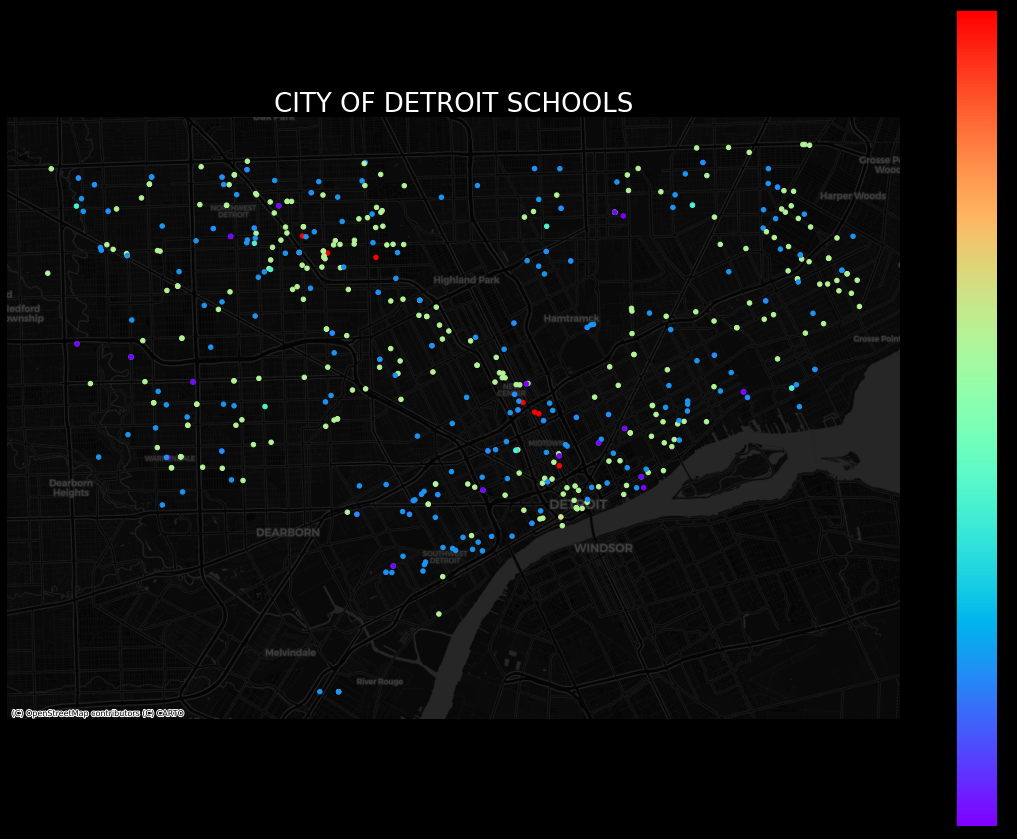

In [ ]:
gdfProj = gdf.to_crs('EPSG:3857')
fig, ax = plt.subplots(figsize=(20,15),facecolor='black')

gdfProj.plot(ax=ax, markersize=20, column = col[7], legend='true', cmap='rainbow')
plt.title("CITY OF DETROIT SCHOOLS", fontsize=26, color='white')

ax.set_axis_off()

ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)

## ETL Data Pipeline
### Testing automated download/uploads
Download zipped shapefiles from public ArcREST server endpoints, create new ArcGIS Item with Python API, publish as Feature Service to ArcGIS Online Account

In [ ]:
# endpoint for SEMCOG Building footprint data
dataURL = 'https://www.arcgis.com/sharing/rest/content/items/5b6f776bfec746ddbac968e3db9f8abb/data'
!wget {dataURL}

--2021-10-14 23:46:39--  https://www.arcgis.com/sharing/rest/content/items/5b6f776bfec746ddbac968e3db9f8abb/data
Resolving www.arcgis.com (www.arcgis.com)... 18.234.22.251, 52.23.2.231, 18.234.22.3, ...
Connecting to www.arcgis.com (www.arcgis.com)|18.234.22.251|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ago-item-storage.s3.us-east-1.amazonaws.com/5b6f776bfec746ddbac968e3db9f8abb/Building_Footprints.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEMj%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIQDWEwV4vVNqQRJCqatPUV9u7zYuVu8DR3RodWHtsQYRtAIgWyA30BeSP1d5gKHz3Ylrno8X5yrIwqQbAMmWuVlGqS4q%2BgMIURAAGgw2MDQ3NTgxMDI2NjUiDGvV5vIW4gnxVvZ8birXA7moQHYmAUHEK8NE8IRSsc1W89AzU3m7AwGSZG3X0VPZA%2Bo72mx4vdv4WROhzEP4zU8IGv5Xp2dNpV3eIvZ%2FYtAUMZcLe02yZvoVXcOASj8yjFN30fCeDVzBHftr%2BiNdpODKcM8l%2FQJqZBA41B2sGgAMkZyqyo9ERYq%2Bgf62qLfjLPz4FFVPHY7kSIc1xW9%2FGAO0g9KHE%2BwEnv%2BzHWyDfzgkleKy6NPtb4lCqIdzYPePon8Nzr8bdV30UkwM4rF%2BKNGf2oJopN94AP6krqAc9Te8NlbCEZqxILLW54nd

In [ ]:
import os

zip_path = os.path.join('/content', 'data.zip')
csv_properties={'title':'Earthquakes around the world from 1800s to early 1900s',
                'description':'Measurements from globally distributed seismometers',
                'tags':'arcgis, python, earthquake, natural disaster, emergency',
                'type':'Shapefile',
                'overwrite':True}
thumbnail_path = os.path.join(data_path, 'semcog.jpeg')

earthquake_csv_item = gis.gis.content.add(item_properties=csv_properties, data=zip_path, thumbnail=thumbnail_path)

In [ ]:
zip_path = os.path.join('/content', 'data.zip')
shpfile = gis.gis.content.add({'type':'Feature Service','overwrite':True}, zip_path)

In [ ]:
#zip_path = os.path.join('/content', 'Building_Footprints.zip')
shp = gis.gis.content.add({'type':'File Geodatabase','overwrite':True}, zip_path)
shp.publish(file_type='Feature Service')

In [ ]:
shp

<Item title:"semcogBuildings" type:File Geodatabase owner:LocationArtistry>

In [ ]:
zip_path = os.path.join('/content', 'Current_City_of_Detroit_Neighborhoods.zip')
shpfile = gis.gis.content.add({'type':'Shapefile','overwrite':True}, zip_path)
shpfile.publish(file_type='Shapefile')

In [ ]:
shpfile.publish(file_type='Shapefile')

<Item title:"Current_City_of_Detroit_Neighborhoods" type:Feature Layer Collection owner:LocationArtistry>

## Data ETL Production Workflow
Some of the sources and be directly download via wget    
Others will need to be firsy discovered via ArcREST helper library, queried as GeoPandas GeoDataframe, exported to GeoJSON from GDF, add as AGOL Item, published a Service to AGOL.   
While the current process requires user input for each data source, once the target layers are known, this process could be easily automated and converted into a script.

1.   SEMCOG Buildings -> download using !wget
2.   FAA UAS Facilty Zones -> upload to colab
3.   MDOT Traffic Volumes -> upload to colab
4.   Detroit Schools -> upload to colab
4.   Detroit Open Data GDF -> City Boundary, Parks





In [ ]:
# first download from SEMCOG Building footprint data
dataURL = ['https://www.arcgis.com/sharing/rest/content/items/5b6f776bfec746ddbac968e3db9f8abb/data']
!wget {dataURL[0]}

--2021-10-15 19:34:27--  https://www.arcgis.com/sharing/rest/content/items/5b6f776bfec746ddbac968e3db9f8abb/data
Resolving www.arcgis.com (www.arcgis.com)... 18.234.22.45, 52.23.2.231, 18.234.22.25, ...
Connecting to www.arcgis.com (www.arcgis.com)|18.234.22.45|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ago-item-storage.s3.us-east-1.amazonaws.com/5b6f776bfec746ddbac968e3db9f8abb/Building_Footprints.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjENz%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLWVhc3QtMSJHMEUCIGBHDLg12LYW0GrnSIOBmJvN2%2FxFlChCPyxwDFx%2B0GCkAiEAxgKGKi03NpNETJBXIKhjLowZ1a4WMRZJfwU4UNXAMu0q%2BgMIZBAAGgw2MDQ3NTgxMDI2NjUiDB4P0yAfxxdL6DEWqSrXA%2FEHH7HiftkdTgT4bwGfAz4012KlUG7K%2BYpbjvHBqDgTJw1SaFjKV1vZ7kdKxbufpuvcuZBAI6uF%2B05CY05IPxQeem0eefvGVT5kf7fYfE4%2Bx%2FIdnqtDFwho5j5xYpnyW%2FsxR6AvEJ9uKf6XyW1n3rkd%2FE4PQFg0wYBZqRW4hrWxgugwDT1UXubK%2FNkb%2BWwTluxUvuxS9pIkq4DQ%2FF3XZayr%2BHiFhd0OtMIoJtUe8FKSTFU6IJBluYqkUsKkkpr3WfE%2FWprWl9ePIxZIP0DOHZwdkgQGC68

In [ ]:
# manually upload FAA UAS and MDOT Traffic Volumes Data
# Login to AGOL account using custom library
gis = agol()

fileNames = ['2019_Traffic_Volumes.zip','FAA_UAS_FacilityMap_Data_V5.zip','Schools__All_Schools__2018_-_2019_-shp.zip','data']
fileType = ['Shapefile','Shapefile','Shapefile','File Geodatabase']

for i, name in enumerate(fileNames):
  filePath = os.path.join('/content', name)
  newItem = gis.gis.content.add({'type':fileType[i],'overwrite':True}, filePath)
  newItem.publish(file_type=fileType[i])

In [ ]:
# Failed to publish Buildings geodatabase into AGOL with above method
# Trying differing approach via unzip, GeoDataframe, and GeojSON
!unzip 'data'
filePath = os.path.join('/content', 'Building_Footprints.gdb')
gdf = gpd.read_file(filePath, driver='FileGDB', layer=0)

In [ ]:
# Successfully read into a GeoDataframe
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1674743 entries, 0 to 1674742
Data columns (total 8 columns):
 #   Column        Non-Null Count    Dtype   
---  ------        --------------    -----   
 0   building_id   1674743 non-null  int64   
 1   median_hgt    1644737 non-null  float64 
 2   source        1674743 non-null  object  
 3   shapelength   1674743 non-null  float64 
 4   shapearea     1674743 non-null  float64 
 5   SHAPE_Length  1674743 non-null  float64 
 6   SHAPE_Area    1674743 non-null  float64 
 7   geometry      1674743 non-null  geometry
dtypes: float64(5), geometry(1), int64(1), object(1)
memory usage: 102.2+ MB


In [ ]:
# Next convert to GeoJSON for upload to AGOL
gdfGeoJSON = gdf.to_json()

In [ ]:
# content.add and publish fail again, perhaps due to large number of polygon records
gdfItem = gis.gis.content.add({'type':'GeoJson','title':'semcogBuild', 'overwrite':True}, gdfGeoJSON)
gdfItem.publish(file_type='geojson')
# Manually uploading through AGOL GUI as last resort

In [ ]:
# ArcREST endpoint for Detroit Open Data
# Select desired layer by number in list
restURL = 'https://services2.arcgis.com/qvkbeam7Wirps6zC/ArcGIS/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

In [ ]:
gdf.to_file("Detroit.geojson", driver='GeoJSON')

In [ ]:
# converts the data into GeoJSON format, not necessary in this particular pipeline
gdfGeoJSON = gdf.to_json()

In [ ]:
filePath = os.path.join('/content', 'Detroit.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

<Item title:"Detroit" type:Feature Layer Collection owner:LocationArtistry>

In [ ]:
!pip install mapclassify
from mapclassify import classify
gdf.explore()

In [ ]:
# ArcREST endpoint for Detroit Open Data
# Select desired layer by number in list
restURL = 'https://services2.arcgis.com/qvkbeam7Wirps6zC/ArcGIS/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

In [ ]:
gdf.to_file("data.geojson", driver='GeoJSON')

In [ ]:
filePath = os.path.join('/content', 'data.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

<Item title:"data" type:Feature Layer Collection owner:LocationArtistry>

### Creating buffer to be used in data model
While the layers have already been published to AGOL, this will attempt to generate the inital query and perform a buffer on the non-polygon layers.  ArcGIS only has a buffer feature available in arcpy, which can not be accessed outside of it's software system.  With the data already being in a GeoDataframe, spatial operations can be performed in the notebook before data is published.  

In [ ]:
# Now working published to our AGOL Server
restURL = 'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

Credentials Needed (YES/NO)? NO


'MAPSERVER OBJECT CREATED'

<ArcServer: "services5.arcgis.com" ("UDWrEU6HdWNYIRIV")>

'0 - Service Name: 2019_Traffic_Volumes -  Service Type: FeatureServer'

'1 - Service Name: Building_Footprints -  Service Type: FeatureServer'

'2 - Service Name: Building_Footprints_semcog -  Service Type: FeatureServer'

'3 - Service Name: data -  Service Type: FeatureServer'

'4 - Service Name: Detroit -  Service Type: FeatureServer'

'5 - Service Name: FAA_UAS_FacilityMap_Data_V5 -  Service Type: FeatureServer'

'6 - Service Name: FULTON_SAMP_PARC -  Service Type: FeatureServer'

'7 - Service Name: NHBP_LANDS_2019 -  Service Type: FeatureServer'

'8 - Service Name: NHD_H_04050001_HU8_Shape -  Service Type: FeatureServer'

'9 - Service Name: SAMPLE_DESIGN -  Service Type: FeatureServer'

'10 - Service Name: Schools_All_Schools_2018_2019_shp -  Service Type: FeatureServer'

'11 - Service Name: service_6c3cc397d0f44f79a8c0bae463d73639 -  Service Type: FeatureServer'

'12 - Service Name: service_712be771664348a08642788e9e10e3e6 -  Service Type: FeatureServer'

'13 - Service Name: WATER_SAMPLING_2020 -  Service Type: FeatureServer'

'14 - Service Name: WATER_SAMPLING_2020_ee464df349124e9ea9635b0d4a9b47b5 -  Service Type: FeatureServer'

'15 - Service Name: WQ_HYDRO_SEP2019 -  Service Type: FeatureServer'

'16 - Service Name: ZOOM_EXTENTS -  Service Type: FeatureServer'

'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services -  '

Select index of subservice: 10


'ARCSERVICE OBJECT CREATED - https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/Schools_All_Schools_2018_2019_shp/FeatureServer'

'0 - Schools_All_Schools_2018_2019_shp'

Select index of Layer: 0


'LAYER CREATED - Schools_All_Schools_2018_2019_shp - id: 0 - url: https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/Schools_All_Schools_2018_2019_shp/FeatureServer/0'

'Schools_All_Schools_2018_2019_shp - capabilities: Query - query formats: JSON, geoJSON, PBF - count: 0'

SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


,FID,ObjectId,EntityCode,EntityOffi,AgreementN,EntityType,EntityTy_1,EntityTy_2,EntityTy_3,EntityTy_4,EntityTy_5,EntityCoun,EntityCo_1,EntityChar,EntityCh_1,EntityGeog,EntityGe_1,EntityNCES,EntityLoca,EntityLo_1,EntityAuth,EntityActu,EntityStat,EntityOpen,EntityClos,EntityAu_1,EntityAc_1,EntityFIPS,EnttiyREMC,EntitySche,EntityEarl,ReceivesTr,Receives_1,EntityReli,EntityRe_1,EntityEmai,EntityPhon,EntityPh_1,EntityFax,EntityFaxE,EntityLead,EntityLe_1,EntityLe_2,EntityPhys,EntityPh_2,EntityPh_3,EntityPh_4,EntityMail,EntityMa_1,EntityMa_2,EntityMa_3,EarlyMiddl,geometry
0,1,1,990005850,Primary Colors Early Childhood Center LLC,990005850,52,Other Non-School Recipient,4,Non-School Recipient,7,Other,82,Wayne,,,82015,Detroit Public Schools Community District,,,,,,Open-Active,1445817600000,,,,26163,0,,CCare,0,,,,msloraine@primarycolorsecc.com,3132723505,,0,,Mrs.,Loraine,Smith-Hines,18605 Schoolcraft,Detroit,MI,482232901,18605 Schoolcraft,Detroit,MI,48223,,POINT (-83.22380 42.38628)
1,2,2,,,82742,0,,1,District,4,PSA,82,Wayne,05133,Grand Valley State University,82015,Detroit Public Schools Community District,2601008,11,City: Large,"GenEd,SpecEd","GenEd,SpecEd",Open-Active,1341100800000,,"KG,1,2,3,4,5,6,7,8","KG,1,2,3,4,5,6,7,8",26163,20,,,0,,,,scott.cairo@cornerstonecharters.org,3134864626,,0,,Mrs.,Kalyani,Bhatt,19900 Mcintyre St,Detroit,MI,48219,19900 MCINTYRE ST,DETROIT,MI,482191263,,POINT (-83.26289 42.43692)
2,3,3,990000178,Kiddie University Child Care Center,990000178,52,Other Non-School Recipient,4,Non-School Recipient,7,Other,82,Wayne,,,82030,Dearborn City School District,,,,,,Open-Active,1241654400000,,,,26163,0,,,0,,,,Kuniversity1@aol.com,3132285802,,0,,Ms.,Janet,Phillips,16341 WEST WARREN AVE,DETROIT,MI,482283702,16341 West Warren Ave,Detroit,MI,48228,,POINT (-83.20576 42.34332)
3,4,4,990000138,Towering Glory Ascension Ministry Church,990000138,52,Other Non-School Recipient,4,Non-School Recipient,7,Other,82,Wayne,,,82015,Detroit Public Schools Community District,,,,,,Open-Active,1241481600000,,,,26163,0,,,0,,,,skboles19@comcast.net,3135156072,,0,,Mr.,Stephen,Boles,18701 GRAND RIVER AVE # 245,DETROIT,MI,482232214,18701 GRAND RIVER AVE # 245,DETROIT,MI,482232214,,POINT (-83.22568 42.40345)
4,5,5,990000189,Exceptional Deliverance Ministries,990000189,52,Other Non-School Recipient,4,Non-School Recipient,7,Other,82,Wayne,,,82015,Detroit Public Schools Community District,,,,,,Open-Active,1244419200000,,,,26163,0,,,0,,,,except.deliveranceminstries@yahoo.com,3136336712,,0,,Ms.,Donna,Knight,19774 FORRER ST,DETROIT,MI,482352307,19774 FORRER ST,DETROIT,MI,482352307,,POINT (-83.20269 42.43692)


In [ ]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# reporject from WGS 84/EPSG=4326 to Michigan State Plane South - EPSG=26990
gdf = gdf.to_crs(epsg=26990)

In [ ]:
# With units as meters, create a 500 m buffer around the schools
gdfBuf = gdf.buffer(500)

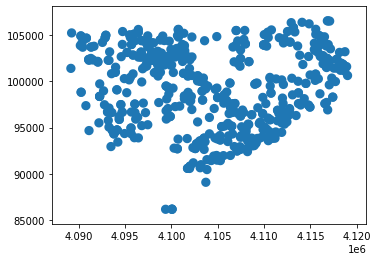

In [ ]:
gdfBuf.plot()

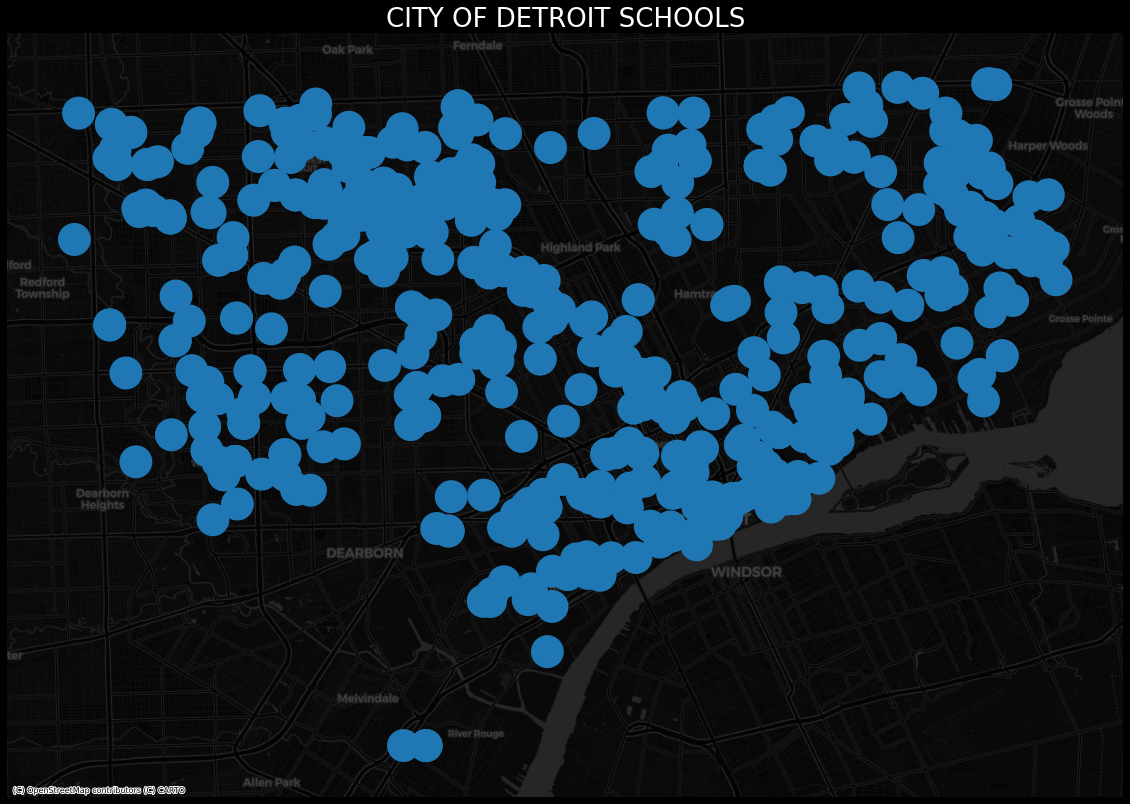

In [ ]:
# plot 500 m school buffers with basemap

gdfProj = gdfBuf.to_crs('EPSG:3857')
fig, ax = plt.subplots(figsize=(20,15),facecolor='black')

gdfProj.plot(ax=ax)
plt.title("CITY OF DETROIT SCHOOLS", fontsize=26, color='white')

ax.set_axis_off()

ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)

In [ ]:
# very new geoPandas ability to create an interactive map, not yet working in Colab
#import folium
#!pip install mapclassify
#import mapclassify
#gdfBuf.explore('polygon')

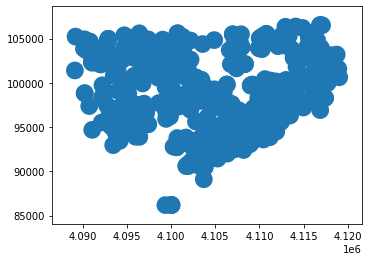

In [ ]:
# change out the original geometry for buffered polygons
gdf['geometry'] = gdf.geometry.buffer(500)
gdf.plot()

In [ ]:
col

Index(['FID', 'ObjectId', 'EntityCode', 'EntityOffi', 'AgreementN',
       'EntityType', 'EntityTy_1', 'EntityTy_2', 'EntityTy_3', 'EntityTy_4',
       'EntityTy_5', 'EntityCoun', 'EntityCo_1', 'EntityChar', 'EntityCh_1',
       'EntityGeog', 'EntityGe_1', 'EntityNCES', 'EntityLoca', 'EntityLo_1',
       'EntityAuth', 'EntityActu', 'EntityStat', 'EntityOpen', 'EntityClos',
       'EntityAu_1', 'EntityAc_1', 'EntityFIPS', 'EnttiyREMC', 'EntitySche',
       'EntityEarl', 'ReceivesTr', 'Receives_1', 'EntityReli', 'EntityRe_1',
       'EntityEmai', 'EntityPhon', 'EntityPh_1', 'EntityFax', 'EntityFaxE',
       'EntityLead', 'EntityLe_1', 'EntityLe_2', 'EntityPhys', 'EntityPh_2',
       'EntityPh_3', 'EntityPh_4', 'EntityMail', 'EntityMa_1', 'EntityMa_2',
       'EntityMa_3', 'EarlyMiddl', 'geometry'],
      dtype='object')

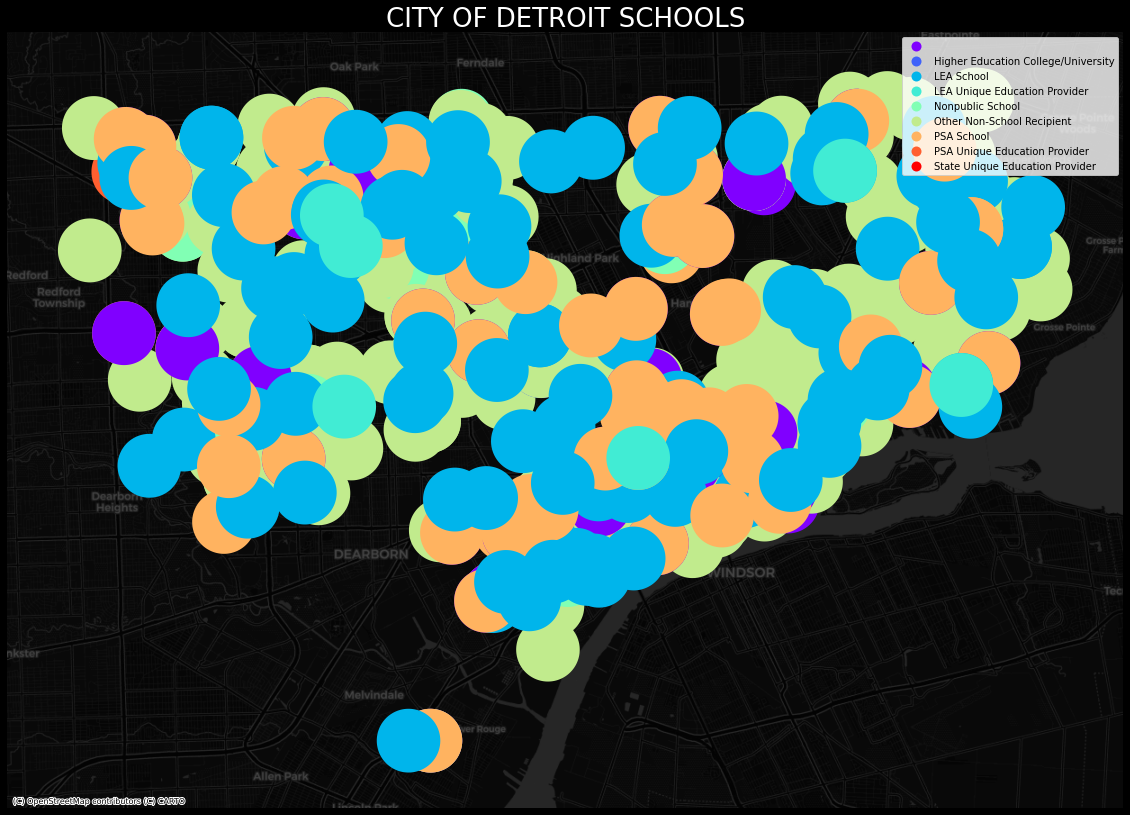

In [ ]:
# replot with original gdf with buffer polygon geometry
col = gdf.columns

gdfProj = gdf.to_crs('EPSG:3857')
fig, ax = plt.subplots(figsize=(20,15),facecolor='black')
gdfProj.plot(ax=ax, column = col[6], legend='true', cmap='rainbow')
plt.title("CITY OF DETROIT SCHOOLS", fontsize=26, color='white')
ax.set_axis_off()

ctx.add_basemap(ax, source=ctx.providers.CartoDB.DarkMatter)

## Data Flow, Processing, and Loading Pipeline
## FINISHED WORKFLOW
End result will be analysis ready polygon layers for Schools, UAS Zones, Parks, Traffic Counts, and Buildings.  Analysis ready layers will contain either only a presence/absence of the feture, or the geometry plus a normalized impedence attribute.  Data will be published as Feature Service to AGOL account.  Will start with data from inital sources to avoid any additional issue with queries from our own AGOL server, which were occuring with some of the processed data.

### Schools

In [ ]:
# Now working with data published to our AGOL Server
# login to server if necessary
gis = agol()

# Use agol class library working in our own server
search = gis.search('school',10)
item = gis.getItem(search[0].id)
layer = item.getLayer()
gdf = layer.layerQuery()
gdf.head()

0 - Schools__All_Schools__2018_-_2019_-shp - 0a9860d29e0f40639cd2b94931ca046f - Feature Service - ['/Categories/AIRSPACE FINAL'] - 2021-10-15 15:41:12
1 - Schools__All_Schools__2018_-_2019_-shp - 5afe7e85a0b34a1d9db8d9eea5756522 - Shapefile - [] - 2021-10-15 15:41:07


<Item title:"Schools__All_Schools__2018_-_2019_-shp" type:Feature Layer Collection owner:LocationArtistry>

'0 - Schools_All_Schools_2018_2019_shp'

Select index of Layer: 0
SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


,FID,ObjectId,EntityCode,EntityOffi,AgreementN,EntityType,EntityTy_1,EntityTy_2,EntityTy_3,EntityTy_4,EntityTy_5,EntityCoun,EntityCo_1,EntityChar,EntityCh_1,EntityGeog,EntityGe_1,EntityNCES,EntityLoca,EntityLo_1,EntityAuth,EntityActu,EntityStat,EntityOpen,EntityClos,EntityAu_1,EntityAc_1,EntityFIPS,EnttiyREMC,EntitySche,EntityEarl,ReceivesTr,Receives_1,EntityReli,EntityRe_1,EntityEmai,EntityPhon,EntityPh_1,EntityFax,EntityFaxE,EntityLead,EntityLe_1,EntityLe_2,EntityPhys,EntityPh_2,EntityPh_3,EntityPh_4,EntityMail,EntityMa_1,EntityMa_2,EntityMa_3,EarlyMiddl,geometry
0,1,1,990005850,Primary Colors Early Childhood Center LLC,990005850,52,Other Non-School Recipient,4,Non-School Recipient,7,Other,82,Wayne,,,82015,Detroit Public Schools Community District,,,,,,Open-Active,1445817600000,,,,26163,0,,CCare,0,,,,msloraine@primarycolorsecc.com,3132723505,,0,,Mrs.,Loraine,Smith-Hines,18605 Schoolcraft,Detroit,MI,482232901,18605 Schoolcraft,Detroit,MI,48223,,POINT (-83.22380 42.38628)
1,2,2,,,82742,0,,1,District,4,PSA,82,Wayne,05133,Grand Valley State University,82015,Detroit Public Schools Community District,2601008,11,City: Large,"GenEd,SpecEd","GenEd,SpecEd",Open-Active,1341100800000,,"KG,1,2,3,4,5,6,7,8","KG,1,2,3,4,5,6,7,8",26163,20,,,0,,,,scott.cairo@cornerstonecharters.org,3134864626,,0,,Mrs.,Kalyani,Bhatt,19900 Mcintyre St,Detroit,MI,48219,19900 MCINTYRE ST,DETROIT,MI,482191263,,POINT (-83.26289 42.43692)
2,3,3,990000178,Kiddie University Child Care Center,990000178,52,Other Non-School Recipient,4,Non-School Recipient,7,Other,82,Wayne,,,82030,Dearborn City School District,,,,,,Open-Active,1241654400000,,,,26163,0,,,0,,,,Kuniversity1@aol.com,3132285802,,0,,Ms.,Janet,Phillips,16341 WEST WARREN AVE,DETROIT,MI,482283702,16341 West Warren Ave,Detroit,MI,48228,,POINT (-83.20576 42.34332)
3,4,4,990000138,Towering Glory Ascension Ministry Church,990000138,52,Other Non-School Recipient,4,Non-School Recipient,7,Other,82,Wayne,,,82015,Detroit Public Schools Community District,,,,,,Open-Active,1241481600000,,,,26163,0,,,0,,,,skboles19@comcast.net,3135156072,,0,,Mr.,Stephen,Boles,18701 GRAND RIVER AVE # 245,DETROIT,MI,482232214,18701 GRAND RIVER AVE # 245,DETROIT,MI,482232214,,POINT (-83.22568 42.40345)
4,5,5,990000189,Exceptional Deliverance Ministries,990000189,52,Other Non-School Recipient,4,Non-School Recipient,7,Other,82,Wayne,,,82015,Detroit Public Schools Community District,,,,,,Open-Active,1244419200000,,,,26163,0,,,0,,,,except.deliveranceminstries@yahoo.com,3136336712,,0,,Ms.,Donna,Knight,19774 FORRER ST,DETROIT,MI,482352307,19774 FORRER ST,DETROIT,MI,482352307,,POINT (-83.20269 42.43692)


In [ ]:
# reproject from WGS 84/EPSG=4326 to Michigan State Plane South - EPSG=26990
gdf = gdf.to_crs(epsg=26990)
# With units as meters, create a 100 m buffer around the schools
gdfBuf = gdf.buffer(100)
# returns a GeoSeries that only contains feature geometries

In [ ]:
# convert to GeoJSON file output from GeoDatadrame, necessary for Item Publishing
gdfBuf.to_file("detSchools100m.geojson", driver='GeoJSON')
filePath = os.path.join('/content', 'detSchools100m.geojson')
# Add Item as AGOL content, GeoJson as file type, publish as Feature Service
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')
# Must delete 'geometry' attribute from AGOL Service for future Notebook Processing!

<Item title:"detSchools100m" type:Feature Layer Collection owner:LocationArtistry>

### Parks

0 - buildingsClippedDet - 33911375c216416ba48de85019faae9f - Feature Service - ['/Categories/AIRSPACE FINAL'] - 2021-10-18 01:21:12
1 - Building_Footprints_semcog - 646113f2fd834db99298784db361ee94 - Feature Service - [] - 2021-10-15 20:32:47
2 - Detroit Parks - 8ab89580ab4d44f0b6f2ee943d2126aa - Feature Service - ['/Categories/AIRSPACE FINAL'] - 2021-10-16 01:27:13


<Item title:"Detroit Parks" type:Feature Layer Collection owner:LocationArtistry>
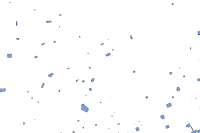

'0 - data_0'

Select index of Layer: 0
SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


,ogc_fid,objectid,name,park_id,acres,class,basketball,horseshoes,tennis,walking,dog_run,picnic,playground,restrooms,sled_hill,trails,address,baseball,soccer,golf,chess,natural_area,details,globalid,lastmowdate,nextmowdate,Shape__Area,Shape__Length,Shape__Area_2,Shape__Length_2,geometry
0,1,1,Heilmann Playfield,175,30.98,Community,1.0,None,None,None,None,None,1.0,None,None,None,19601 Crusade,1.0,None,None,None,None,None,5fa4d009-7078-442a-87ea-e9282ccb8b61,None,None,1334572.0,5665.177,227819.871094,2343.141458,"POLYGON ((-82.96313 42.44262, -82.96092 42.442..."
1,2,2,Simanek,157,6.56,Neighborhood,1.0,None,None,None,None,None,1.0,None,None,None,7461 Rutland,1.0,None,None,None,None,None,e24924b0-c353-479d-af2f-1680f797fcce,None,None,287508.3,2576.558,48933.269531,1062.439787,"POLYGON ((-83.21574 42.34594, -83.21567 42.345..."
2,3,3,Brewer,161,8.28,Neighborhood,NaN,None,None,1,None,None,1.0,None,None,None,4535 Fairview,NaN,None,None,None,None,None,d51a87e7-7222-463e-b27e-c77a8e04b39a,None,None,356081.1,2704.827,60675.652344,1116.643706,"POLYGON ((-82.98835 42.38367, -82.98833 42.383..."
3,4,4,Egan-Wish,165,10.28,Neighborhood,1.0,None,None,None,None,None,1.0,None,None,None,19800 Schoenherr,1.0,None,None,None,None,None,e8c8b43e-ea1d-4208-9504-f8ca8568f46d,None,None,447627.6,2708.323,76422.335938,1119.374799,"POLYGON ((-82.98517 42.44447, -82.98477 42.444..."
4,5,5,St. Hedwigg,227,13.56,Neighborhood,1.0,None,None,1,None,None,1.0,None,None,None,2900 Junction,1.0,None,None,None,None,None,4b02e4bb-d77e-416a-8001-02d6498bd056,None,None,587221.6,3289.601,99879.101562,1355.541290,"POLYGON ((-83.11255 42.32583, -83.11083 42.326..."


In [ ]:
# Now working with data published to our AGOL Server
# login to server if necessary
#gis = agol()
# Use agol class library working in our own server
search = gis.search('parks',10)
item = gis.getItem(search[2].id)
layer = item.getLayer()
gdf = layer.layerQuery()
gdf.head()

In [ ]:
# reproject from WGS 84/EPSG=4326 to Michigan State Plane South - EPSG=26990
gdf = gdf.to_crs(epsg=26990)
# No need for buffer around park polygons, remove all attributes except geometry
gdf = gdf[['geometry']]
# returns a GeoSeries that only contains feature geometries

In [ ]:
# convert to GeoJSON file output from GeoDatadrame, necessary for Item Publishing
gdf.to_file("detParks.geojson", driver='GeoJSON')
filePath = os.path.join('/content', 'detParks.geojson')
# Add Item as AGOL content, GeoJson as file type, publish as Feature Service
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')
# Must delete 'geometry' attribute from AGOL Service for future Notebook Processing!

<Item title:"detParks" type:Feature Layer Collection owner:LocationArtistry>

### FAA Zones

0 - FAA_UAS_FacilityMap_Data_V5 - eddd31c74c4a41d2be13caa2d5b1de7c - Shapefile - [] - 2021-10-15 15:40:58
1 - FAA_UAS_FacilityMap_Data_V5 - 4b7e59d3d6044bc1809d1e6009b7d11d - Feature Service - ['/Categories/AIRSPACE FINAL'] - 2021-10-16 01:28:35


<Item title:"FAA_UAS_FacilityMap_Data_V5" type:Feature Layer Collection owner:LocationArtistry>
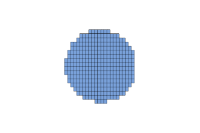

'0 - FAA_UAS_FacilityMap_Data_V5'

Select index of Layer: 0
SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


,FID,OBJECTID,CEILING,UNIT,MAP_EFF,LAST_EDIT,LATITUDE,LONGITUDE,GLOBALID,ARPT_COUNT,APT1_FAAID,APT1_ICAO,APT1_NAME,APT1_LAANC,APT2_FAAID,APT2_ICAO,APT2_NAME,APT2_LAANC,APT3_FAAID,APT3_ICAO,APT3_NAME,APT3_LAANC,APT4_FAAID,APT4_ICAO,APT4_NAME,APT4_LAANC,APT5_FAAID,APT5_ICAO,APT5_NAME,APT5_LAANC,AIRS_COUNT,AIRSPACE_1,AIRSPACE_2,AIRSPACE_3,AIRSPACE_4,AIRSPACE_5,REGION,APT1_Enabl,APT2_Enabl,APT3_Enabl,APT4_Enabl,APT5_Enabl,Shape__Are,Shape__Len,Shape__Area,Shape__Length,geometry
0,1,199646,400,Feet,10/7/2021,12/7/2017,42.337507,-83.020841,b4e4e6c3-7629-4a3f-95fe-e2449e2bd514,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164190e+06,4365.267742,"POLYGON ((-83.02501 42.33334, -83.02501 42.341..."
1,2,199647,400,Feet,10/7/2021,12/7/2017,42.337507,-83.012508,83167bdd-f043-4134-82cd-a326a17574ca,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164190e+06,4365.267742,"POLYGON ((-83.01667 42.33334, -83.01667 42.341..."
2,3,199648,400,Feet,10/7/2021,12/7/2017,42.337507,-83.004174,5271b0a8-91bb-477d-9019-7c028e194334,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164190e+06,4365.267519,"POLYGON ((-83.00834 42.33334, -83.00834 42.341..."
3,4,199778,400,Feet,10/7/2021,12/7/2017,42.345840,-83.045841,23858aba-eaa8-4e61-886b-576eb2938f99,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164344e+06,4365.600425,"POLYGON ((-83.05001 42.34167, -83.05001 42.350..."
4,5,199779,400,Feet,10/7/2021,12/7/2017,42.345840,-83.037508,f1ad5e1f-789a-49c5-a9f0-50a4ce5f9272,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164344e+06,4365.600203,"POLYGON ((-83.04167 42.34167, -83.04167 42.350..."


In [ ]:
# Now working with data published to our AGOL Server
# login to server if necessary
#gis = agol()
# Use agol class library working in our own server
search = gis.search('FAA',10)
item = gis.getItem(search[1].id)
layer = item.getLayer()
gdf = layer.layerQuery()
gdf.head()

In [ ]:
# data normalization process via: https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
gdf = gdf.to_crs(epsg=26990)
gdfNorm = gdf.copy()
col = 'CEILING'
# Reverse normalization!  Higher values should have lower impedence
#gdfNorm[col] = (gdfNorm[col] - gdfNorm[col].min()) / (gdfNorm[col].max() - gdfNorm[col].min())    
gdfNorm[col] = abs((gdfNorm[col] - gdfNorm[col].max()) / (gdfNorm[col].min() - gdfNorm[col].max()))
# view normalized data
gdfNorm['CEILING'].value_counts()

0.000    189
1.000     52
0.750     36
0.500     20
0.250     20
0.625      4
0.875      4
Name: CEILING, dtype: int64

In [ ]:
gdfNorm = gdfNorm[['CEILING','geometry']]
gdfNorm.head()

,CEILING,geometry
0,0.0,"POLYGON ((4110565.556 93446.776, 4110550.807 9..."
1,0.0,"POLYGON ((4111252.244 93457.754, 4111237.403 9..."
2,0.0,"POLYGON ((4111938.931 93468.800, 4111923.998 9..."
3,0.0,"POLYGON ((4108491.011 94339.759, 4108476.536 9..."
4,0.0,"POLYGON ((4109177.611 94350.532, 4109163.044 9..."


In [ ]:
gdfNorm.to_file("detUAV.geojson", driver='GeoJSON')

filePath = os.path.join('/content', 'detUAV.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

<Item title:"detUAV" type:Feature Layer Collection owner:LocationArtistry>

### Traffic Counts

0 - 2019_Traffic_Volumes - b8728584df204b2d9fe588a8b8f6699d - Shapefile - [] - 2021-10-15 15:39:38
1 - 2019_Traffic_Volumes - a5a5649887b241d6a3efdc8729de01fc - Feature Service - [] - 2021-10-17 13:00:08
2 - trafficBuffers - c212f79aab4c4875bdf069485b18f8c0 - Feature Service - [] - 2021-10-18 00:06:07
3 - trafficBuffersClip - 455d14c3203e4981a46998ddb8278437 - Shapefile - [] - 2021-10-18 00:24:05
4 - trafficBuffersClip - afa88351de0e4b4c85ae5e11fc158b4f - Feature Service - ['/Categories/AIRSPACE FINAL'] - 2021-10-18 03:56:00
5 - trafficBuffers - 19718a32aa544b319240bad5f185a263 - GeoJson - [] - 2021-10-18 00:04:02


<Item title:"trafficBuffersClip" type:Feature Layer Collection owner:LocationArtistry>
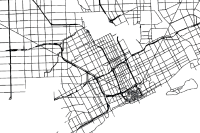

'0 - trafficBuffersClip'

Select index of Layer: 0
SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


,FID,Aadt,Shape__Are,Shape__Len,Shape_Leng,Shape_Area,Shape__Area,Shape__Length,geometry
0,1,4818,87431.372479,6497.980324,6497.979958,87431.356809,87431.332031,6497.979958,"POLYGON ((-83.07666 42.31988, -83.07667 42.319..."
1,2,119426,41216.959061,3083.355712,3083.355725,41216.952618,41216.960938,3083.355725,"POLYGON ((-83.15457 42.38520, -83.15417 42.385..."
2,3,8836,82213.114556,6117.887534,6117.887539,82213.111808,82213.089844,6117.887539,"POLYGON ((-82.97337 42.40201, -82.97338 42.402..."
3,4,26754,10361.471886,809.056315,809.056345,10361.468767,10361.457031,809.056345,"POLYGON ((-83.21668 42.37470, -83.21670 42.374..."
4,5,11065,1687.343946,167.134646,167.134690,1687.343944,1687.320312,167.134690,"POLYGON ((-83.21675 42.37882, -83.21676 42.378..."


In [ ]:
# Now working with data published to our AGOL Server
# login to server if necessary
#gis = agol()

# Use agol class library working in our own server
search = gis.search('traffic',10)
item = gis.getItem(search[4].id)
layer = item.getLayer()
gdf = layer.layerQuery()
gdf.head()

In [ ]:
# reproject from WGS 84/EPSG=4326 to Michigan State Plane South - EPSG=26990
gdf = gdf.to_crs(epsg=26990)
# With units as meters, create a 100 m buffer around the schools
# gdfBuf = gdf.buffer(10)
# returns a GeoSeries that only contains feature geometries

# Traffic Layer previous processing has been clipped and converted into polygons

In [ ]:
# data normalization process via: https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
gdfNorm = gdf.copy()
col = 'Aadt'
# Standard Normalization
gdfNorm[col] = (gdfNorm[col] - gdfNorm[col].min()) / (gdfNorm[col].max() - gdfNorm[col].min())    
# view normalized data
range = gdfNorm['Aadt'].max() - gdfNorm['Aadt'].min()
range

1.0

In [ ]:
gdfNorm = gdfNorm[['Aadt','geometry']]
gdfNorm.head()

,Aadt,geometry
0,0.027727,"POLYGON ((4106332.129 91885.150, 4106331.150 9..."
1,0.688379,"POLYGON ((4099806.498 99044.688, 4099839.316 9..."
2,0.050889,"POLYGON ((4114694.197 101142.561, 4114693.216 ..."
3,0.154176,"POLYGON ((4094707.944 97806.946, 4094706.967 9..."
4,0.063738,"POLYGON ((4094696.602 98264.387, 4094695.624 9..."


In [ ]:
gdfNorm.to_file("trafficNorm.geojson", driver='GeoJSON')

filePath = os.path.join('/content', 'trafficNorm.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

<Item title:"trafficNorm" type:Feature Layer Collection owner:LocationArtistry>

### Buildings

0 - CityStructure - 40e145db4bde4e98b5b001a928448ddb - Web Map - [] - 2021-03-23 18:51:36
1 - buildingsClippedDet - 33911375c216416ba48de85019faae9f - Feature Service - ['/Categories/AIRSPACE FINAL'] - 2021-10-18 01:21:12
2 - Building_Footprints_semcog - 646113f2fd834db99298784db361ee94 - Feature Service - [] - 2021-10-15 20:32:47
3 - Building Footprints - 62316b14a99742e5a580231dea3569ce - Feature Service - [] - 2021-03-23 19:52:48
4 - buildingsClippedDet - 7f25c4f554284914b696adf7a4cf226f - Shapefile - [] - 2021-10-19 18:12:04
5 - ZOOM_EXTENTS - f58269ac3fa64be39f536b77c32a873e - Feature Service - [] - 2021-06-16 14:30:29
6 - Building_Footprints_semcog - 90ebf95cf19644299820e1b785cbd995 - File Geodatabase - [] - 2021-10-15 20:31:11
7 - Building Footprints - 89440fd6ea4941c6b38ef71507cad918 - GeoJson - [] - 2021-03-23 19:41:00


<Item title:"buildingsClippedDet" type:Feature Layer Collection owner:LocationArtistry>
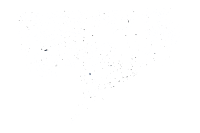

'0 - buildingsClippedDet'

Select index of Layer: 0
SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


,FID,building_i,median_hgt,source,shapelengt,shapearea,SHAPE_Leng,SHAPE_Area,Shape__Area,Shape__Length,geometry
0,1,8187825,15,SANBORN,119.404425,816.255282,119.404425,816.255282,139.074219,49.267770,"POLYGON ((-83.19372 42.38022, -83.19372 42.380..."
1,2,8095554,14,SANBORN,137.524216,1030.923480,137.524216,1030.923480,175.503906,56.715088,"POLYGON ((-83.22439 42.35465, -83.22439 42.354..."
2,3,8019338,23,SANBORN,119.061483,769.449952,119.061483,769.449952,130.816406,49.086928,"POLYGON ((-83.14200 42.31395, -83.14196 42.313..."
3,4,8390534,15,SANBORN,129.358785,943.322663,129.358785,943.322663,160.925781,53.411132,"POLYGON ((-82.93391 42.41718, -82.93403 42.417..."
4,5,8392367,20,SANBORN,174.488601,1713.975509,174.488601,1713.975509,292.382812,72.084447,"POLYGON ((-82.91158 42.41780, -82.91154 42.417..."


In [ ]:
# Now working with data published to our AGOL Server
# login to server if necessary
#gis = agol()

# Use agol class library working in our own server
search = gis.search('build',10)
item = gis.getItem(search[1].id)
layer = item.getLayer()
gdf = layer.layerQuery()
gdf.head()

In [ ]:
gdf.info()
# Still only loading 2000 buildings with query and Updated Service Definitions!

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FID            2000 non-null   int64   
 1   building_i     2000 non-null   int64   
 2   median_hgt     2000 non-null   int64   
 3   source         2000 non-null   object  
 4   shapelengt     2000 non-null   float64 
 5   shapearea      2000 non-null   float64 
 6   SHAPE_Leng     2000 non-null   float64 
 7   SHAPE_Area     2000 non-null   float64 
 8   Shape__Area    2000 non-null   float64 
 9   Shape__Length  2000 non-null   float64 
 10  geometry       2000 non-null   geometry
dtypes: float64(6), geometry(1), int64(3), object(1)
memory usage: 172.0+ KB


In [ ]:
# Attempt 2 - skip query and load the downloaded file directly into GeoPandas
gdf = gpd.read_file('/content/buildingsClippedDet.zip')

In [ ]:
# All of the buildings are there!
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 244111 entries, 0 to 244110
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   building_i  244111 non-null  int64   
 1   median_hgt  244111 non-null  int64   
 2   source      244111 non-null  object  
 3   shapelengt  244111 non-null  float64 
 4   shapearea   244111 non-null  float64 
 5   SHAPE_Leng  244111 non-null  float64 
 6   SHAPE_Area  244111 non-null  float64 
 7   geometry    244111 non-null  geometry
dtypes: float64(4), geometry(1), int64(2), object(1)
memory usage: 14.9+ MB


In [ ]:
# reproject from WGS 84/EPSG=4326 to Michigan State Plane South - EPSG=26990
gdf = gdf.to_crs(epsg=26990)
# No need for buffer around building polygons, save height attribute
# gdf = gdf[['geometry']]
# returns a GeoSeries that only contains feature geometries

In [ ]:
# data normalization process via: https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
gdfNorm = gdf.copy()
col = 'median_hgt'
# Standard Normalization 0 - 1 based on building height
gdfNorm[col] = (gdfNorm[col] - gdfNorm[col].min()) / (gdfNorm[col].max() - gdfNorm[col].min())  
# view normalized data
range = gdfNorm[col].max() - gdfNorm[col].min()
range
gdfNorm[col].value_counts()

0.020633    32345
0.022008    24687
0.019257    20823
0.017882    15642
0.030261    15519
            ...  
0.359010        1
0.240715        1
1.000000        1
0.392022        1
0.214580        1
Name: median_hgt, Length: 217, dtype: int64

In [ ]:
gdfNorm = gdfNorm[[col,'geometry']]
gdfNorm.head()

,median_hgt,geometry
0,0.030261,"POLYGON ((4101535.084 90058.923, 4101536.183 9..."
1,0.017882,"POLYGON ((4095124.763 103633.366, 4095124.741 ..."
2,0.023384,"POLYGON ((4116396.201 104103.817, 4116406.903 ..."
3,0.019257,"POLYGON ((4117092.680 104202.675, 4117090.512 ..."
4,0.027510,"POLYGON ((4114768.277 104225.984, 4114768.284 ..."


In [ ]:
gdfNorm.to_file("buildNorm.geojson", driver='GeoJSON')

filePath = os.path.join('/content', 'buildNorm.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

<Item title:"buildNorm" type:Feature Layer Collection owner:LocationArtistry>

## MODEL GENERATION WORKFLOW


1.   City of Detroit Boundary as raster shape
2.   Use GDAL.Rasterize to add each later to create surface model
3.   Binary layers will contibute either presence/absence
4.   Range layers will retain a value attribute that will need to be normalized between 0 - 1



In [ ]:
# First bring the City boundary back in as a gdf
restURL = 'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

In [ ]:
# Test to check that OGR/GDAL tools are available!
import ogr
import gdal
import osr
from matplotlib.pyplot import imshow
import numpy as np

In [ ]:
gdf = gdf.to_crs(epsg=26990)
gdf.crs

In [ ]:
# from https://pcjericks.github.io/py-gdalogr-cookbook/raster_layers.html#clip-a-geotiff-with-shapefile
pixel_size = 1
NoData_value = -9999
source_ds = ogr.Open(gdf.to_json())
source_layer = source_ds.GetLayer()
x_min, x_max, y_min, y_max = source_layer.GetExtent()
x_res = int((x_max - x_min) / pixel_size)
y_res = int((y_max - y_min) / pixel_size)
target_ds = gdal.GetDriverByName('GTiff').Create('test.tif', x_res, y_res, 1, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, pixel_size, 0, y_max, 0, -pixel_size))
band = target_ds.GetRasterBand(1)
band.SetNoDataValue(NoData_value)
# Rasterize
gdal.RasterizeLayer(target_ds, [1], source_layer, burn_values=[0])

0

In [ ]:
# output has raster located in Africa, may need to try another approach.

In [ ]:
a_raster = np.array([[10,10,1,10,10,10,10],
                     [1,1,1,50,10,10,50],
                     [10,1,1,51,10,10,50],
                     [1,1,1,1,50,10,50]])

In [ ]:
coord = (-106.629773, 35.105389)
w=10
h=10
name="BigI.tif"

In [ ]:
d=gdal.GetDriverByName("GTiff") 
output=d.Create(name,a_raster.shape[1],a_raster.shape[0],1,gdal.GDT_UInt16) 
output.SetGeoTransform((coord[0],w,0,coord[1],0,h)) 
output.GetRasterBand(1).WriteArray(a_raster) 
outsr=osr.SpatialReference() 
outsr.ImportFromEPSG(4326) 
output.SetProjection(outsr.ExportToWkt()) 
output.FlushCache()

In [ ]:
output.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'

array([[10, 10,  1, 10, 10, 10, 10],
       [ 1,  1,  1, 50, 10, 10, 50],
       [10,  1,  1, 51, 10, 10, 50],
       [ 1,  1,  1,  1, 50, 10, 50]], dtype=uint16)

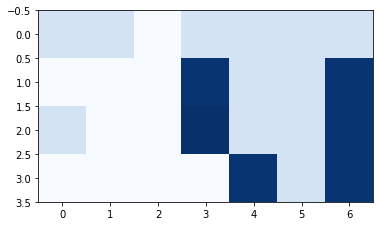

In [ ]:
data=output.ReadAsArray() 
w, h =4, 7 
image = data.reshape(w,h) #assuming X[0] is of shape (400,) .T 
imshow(image, cmap='Blues') #enter bad color to get list 
data 

In [ ]:
format = "GTiff"
driver = gdal.GetDriverByName( format )
metadata = driver.GetMetadata()
metadata

{'DCAP_CREATE': 'YES',
 'DCAP_CREATECOPY': 'YES',
 'DCAP_OPEN': 'YES',
 'DCAP_RASTER': 'YES',
 'DCAP_VIRTUALIO': 'YES',
 'DMD_CREATIONDATATYPES': 'Byte UInt16 Int16 UInt32 Int32 Float32 Float64 CInt16 CInt32 CFloat32 CFloat64',
 'DMD_CREATIONOPTIONLIST': "<CreationOptionList>   <Option name='COMPRESS' type='string-select'>       <Value>NONE</Value>       <Value>LZW</Value>       <Value>PACKBITS</Value>       <Value>JPEG</Value>       <Value>CCITTRLE</Value>       <Value>CCITTFAX3</Value>       <Value>CCITTFAX4</Value>       <Value>DEFLATE</Value>       <Value>LZMA</Value>   </Option>   <Option name='PREDICTOR' type='int' description='Predictor Type (1=default, 2=horizontal differencing, 3=floating point prediction)'/>   <Option name='DISCARD_LSB' type='string' description='Number of least-significant bits to set to clear as a single value or comma-separated list of values for per-band values'/>   <Option name='JPEG_QUALITY' type='int' description='JPEG quality 1-100' default='75'/>   <

In [ ]:
import gdal
driver = gdal.GetDriverByName( 'GTiff' )
dst_filename = 'x_tmp.tif'
dst_ds=driver.Create(dst_filename,512,512,1,gdal.GDT_Byte)

In [ ]:
import numpy, osr
dst_ds.SetGeoTransform([444720, 30, 0, 3751320, 0, -30 ])
srs = osr.SpatialReference()
srs.SetUTM( 11, 1 )
srs.SetWellKnownGeogCS( 'NAD27' )
dst_ds.SetProjection( srs.ExportToWkt() )
raster = numpy.zeros( (512, 512) )
dst_ds.GetRasterBand(1).WriteArray( raster )
# imshow(raster, cmap='gist_earth')
dst_ds.GetDescription()

'x_tmp.tif'

In [ ]:
nmtif = gdal.Open(f'/content/drive/MyDrive/DATA/NM_DEM/nm_relief_color.tif') 
#print(nmtif.GetMetadata()) 
nmtif.GetProjection() 

'PROJCS["NAD_1983_UTM_Zone_13N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","26913"]]'

In [ ]:
from osgeo import osr 
p=osr.SpatialReference() 
p.ImportFromEPSG(26913) 
nmtif.SetProjection(p.ExportToWkt()) 
nmtif.GetProjection()

'PROJCS["NAD83 / UTM zone 13N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26913"]]'

In [ ]:
geoTiffDriver="GTiff" 
driver=gdal.GetDriverByName(geoTiffDriver) 
out=driver.CreateCopy("copy.tif",nmtif,strict=0) 
out.GetProjection()

'PROJCS["NAD83 / UTM zone 13N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-105],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26913"]]'

In [ ]:
nmtif.RasterCount 
band=nmtif.GetRasterBand(1)
values=band.ReadAsArray()

In [ ]:
one= nmtif.GetRasterBand(1).ReadAsArray() 
two = nmtif.GetRasterBand(2).ReadAsArray() 
three= nmtif.GetRasterBand(3).ReadAsArray() 
print(str(one[1100,1100])+","+ str(two[1100,1100])+","+str(three[1100,1100]))

216,189,157


In [ ]:
one=nmtif.GetRasterBand(1) 
two=nmtif.GetRasterBand(2) 
three=nmtif.GetRasterBand(3) 
one.ComputeBandStats() 
two.ComputeBandStats() 
three.ComputeBandStats()

print(str(one.GetMinimum())+","+str(one.GetMaximum())) 


0.0,255.0


In [ ]:
two.GetDescription()    # returns 'band_2' 
two.SetDescription("The Green Band") 
two.GetDescription()  # returns "The Green Band" 

'The Green Band'

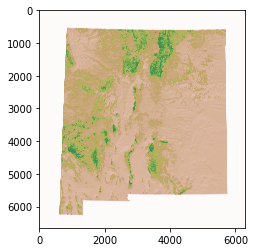

In [ ]:
import numpy as np 
from matplotlib.pyplot import imshow 
%matplotlib inline
data_array=nmtif.ReadAsArray() 
x=np.array(data_array[0]) # x.shape ---> 6652,6300 
w, h =6652, 6300 
image = x.reshape(x.shape[0],x.shape[1]) 
imshow(image, cmap='gist_earth')


### GeoPandas.explore()
Correct dependencies listed below, needed to update version of Folium for Colab.

In [ ]:
!pip install mapclassify
!pip install folium -U

In [ ]:
gdf.explore()

## Buffer Data Processing
After re-projectin to MI State Plane South, GeoDataframe.buffer was readily able to create buffers using meters as distance unit.  This returns a GeoSeries without any of the feature attributes, though using this method allows the original point geometry to be replaced with Polygons in the existing GDF.    

Layers that have a categorical range will need to retain the relevant attribute, while binary classifications such as schools will only need a 0 or 1 pixel value to be added to the model.    

Layers with a binary classification: schools, parks    

Categorical Layers: Buildings, UAS Zones, Traffic Counts


### Add 100m buffer to schools
Remove additional attributes -> republish to cloud

In [ ]:
# Now working with data published to our AGOL Server

# login to server if necessary
# gis = agol()

restURL = 'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

# reproject from WGS 84/EPSG=4326 to Michigan State Plane South - EPSG=26990

gdf = gdf.to_crs(epsg=26990)

# With units as meters, create a 500 m buffer around the schools
gdfBuf = gdf.buffer(100)

# change out the original geometry for buffered polygons
# gdf['geometry'] = gdf.geometry.buffer(500)
# gdf.plot()

gdfBuf.to_file("detSchools100m.geojson", driver='GeoJSON')

filePath = os.path.join('/content', 'detSchools100m.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

In [ ]:
gdf.plot()

In [ ]:
gdf = gdf.to_crs(epsg=26990)
gdf.crs

In [ ]:
gdf.head()

In [ ]:
gdfBuf = gdf.buffer(1000)

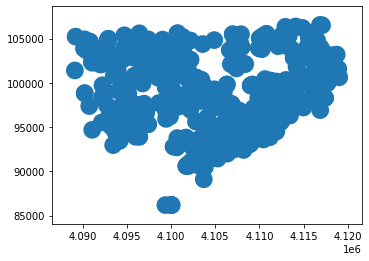

In [ ]:
gdfBuf.plot()

In [ ]:
gdfBuf.head()

0    POLYGON ((4095104.168 99084.898, 4095099.353 9...
1    POLYGON ((4091812.389 104666.229, 4091807.574 ...
2    POLYGON ((4096655.783 94333.747, 4096650.968 9...
3    POLYGON ((4094923.911 100989.777, 4094919.095 ...
4    POLYGON ((4096764.378 104733.383, 4096759.562 ...
dtype: geometry

### FAA UAS Zones no Buffer
Retain attribute -> 'CEILING' -> Normalize range from 0 - 400 to 0 - 1

In [ ]:
# UAS Zones drop all attr except 'ceiling'
restURL = 'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

Credentials Needed (YES/NO)? NO


'MAPSERVER OBJECT CREATED'

<ArcServer: "services5.arcgis.com" ("UDWrEU6HdWNYIRIV")>

'0 - Service Name: 2019_Traffic_Volumes -  Service Type: FeatureServer'

'1 - Service Name: Building_Footprints_semcog -  Service Type: FeatureServer'

'2 - Service Name: data -  Service Type: FeatureServer'

'3 - Service Name: Detroit -  Service Type: FeatureServer'

'4 - Service Name: FAA_UAS_FacilityMap_Data_V5 -  Service Type: FeatureServer'

'5 - Service Name: NHD_H_04050001_HU8_Shape -  Service Type: FeatureServer'

'6 - Service Name: Schools_All_Schools_2018_2019_shp -  Service Type: FeatureServer'

'7 - Service Name: WATER_SAMPLING_2020_ee464df349124e9ea9635b0d4a9b47b5 -  Service Type: FeatureServer'

'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services -  '

Select index of subservice: 4


'ARCSERVICE OBJECT CREATED - https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/FAA_UAS_FacilityMap_Data_V5/FeatureServer'

'0 - FAA_UAS_FacilityMap_Data_V5'

Select index of Layer: 0


'LAYER CREATED - FAA_UAS_FacilityMap_Data_V5 - id: 0 - url: https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/FAA_UAS_FacilityMap_Data_V5/FeatureServer/0'

'FAA_UAS_FacilityMap_Data_V5 - capabilities: Query - query formats: JSON, geoJSON, PBF - count: 0'

SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


,FID,OBJECTID,CEILING,UNIT,MAP_EFF,LAST_EDIT,LATITUDE,LONGITUDE,GLOBALID,ARPT_COUNT,APT1_FAAID,APT1_ICAO,APT1_NAME,APT1_LAANC,APT2_FAAID,APT2_ICAO,APT2_NAME,APT2_LAANC,APT3_FAAID,APT3_ICAO,APT3_NAME,APT3_LAANC,APT4_FAAID,APT4_ICAO,APT4_NAME,APT4_LAANC,APT5_FAAID,APT5_ICAO,APT5_NAME,APT5_LAANC,AIRS_COUNT,AIRSPACE_1,AIRSPACE_2,AIRSPACE_3,AIRSPACE_4,AIRSPACE_5,REGION,APT1_Enabl,APT2_Enabl,APT3_Enabl,APT4_Enabl,APT5_Enabl,Shape__Are,Shape__Len,Shape__Area,Shape__Length,geometry
0,1,199646,400,Feet,10/7/2021,12/7/2017,42.337507,-83.020841,b4e4e6c3-7629-4a3f-95fe-e2449e2bd514,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164190e+06,4365.267742,"POLYGON ((-83.02501 42.33334, -83.02501 42.341..."
1,2,199647,400,Feet,10/7/2021,12/7/2017,42.337507,-83.012508,83167bdd-f043-4134-82cd-a326a17574ca,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164190e+06,4365.267742,"POLYGON ((-83.01667 42.33334, -83.01667 42.341..."
2,3,199648,400,Feet,10/7/2021,12/7/2017,42.337507,-83.004174,5271b0a8-91bb-477d-9019-7c028e194334,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164190e+06,4365.267519,"POLYGON ((-83.00834 42.33334, -83.00834 42.341..."
3,4,199778,400,Feet,10/7/2021,12/7/2017,42.345840,-83.045841,23858aba-eaa8-4e61-886b-576eb2938f99,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164344e+06,4365.600425,"POLYGON ((-83.05001 42.34167, -83.05001 42.350..."
4,5,199779,400,Feet,10/7/2021,12/7/2017,42.345840,-83.037508,f1ad5e1f-789a-49c5-a9f0-50a4ce5f9272,1,DET,KDET,Coleman A Young Muni,1,,,,,,,,,,,,,,,,,1,D,,,,,Central,"107-AA,107-FC,44809-AA",,,,,0.000069,0.033333,1.164344e+06,4365.600203,"POLYGON ((-83.04167 42.34167, -83.04167 42.350..."


In [ ]:
gdf

In [ ]:
# data normalization process via: https://www.geeksforgeeks.org/normalize-a-column-in-pandas/
gdfNorm = gdf.copy()

col = 'CEILING'
gdfNorm[col] = (gdfNorm[col] - gdfNorm[col].min()) / (gdfNorm[col].max() - gdfNorm[col].min())    
  
# view normalized data
gdfNorm['CEILING'].value_counts()

1.000    189
0.000     52
0.250     36
0.500     20
0.750     20
0.375      4
0.125      4
Name: CEILING, dtype: int64

In [ ]:
gdf = gdf[['CEILING','geometry']]

gdf.to_file("detUAVzones.geojson", driver='GeoJSON')

filePath = os.path.join('/content', 'detUAVzones.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

<Item title:"detUAVzones" type:Feature Layer Collection owner:LocationArtistry>

In [ ]:
# UAS Zones - republish with normalized values for 'CEILING'
restURL = 'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

In [ ]:
gdf = gisLayer.layerQuery()

SQL query(ENTER for ALL): 1=1
Fields(ENTER for ALL)? *


'Query unsuccessful for: detUAVzones_0'

### Traffic Counts -> add 10 m Buffer
Normalize by Traffic Count value attribute -> 'AADT': 0 - 1

In [ ]:
# Now working with data published to our AGOL Server
# Needed to update the maxRecordCount in the AGOL Service Definition 
# Was only receiving 2000 record query

restURL = 'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer to generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()


Credentials Needed (YES/NO)? YES
ArcGIS Online USER ID: LocationArtistry
PASSWORD: ··········
set PROTOCOL to "https" from generate token


'MAPSERVER OBJECT CREATED'

<ArcServer: "services5.arcgis.com" ("UDWrEU6HdWNYIRIV")>

'0 - Service Name: 2019_Traffic_Volumes -  Service Type: FeatureServer'

'1 - Service Name: Building_Footprints -  Service Type: FeatureServer'

'2 - Service Name: Building_Footprints_semcog -  Service Type: FeatureServer'

'3 - Service Name: buildingsClippedDet -  Service Type: FeatureServer'

'4 - Service Name: data -  Service Type: FeatureServer'

'5 - Service Name: Detroit -  Service Type: FeatureServer'

'6 - Service Name: detSchools100m -  Service Type: FeatureServer'

'7 - Service Name: detUAVzones -  Service Type: FeatureServer'

'8 - Service Name: FAA_UAS_FacilityMap_Data_V5 -  Service Type: FeatureServer'

'9 - Service Name: FULTON_SAMP_PARC -  Service Type: FeatureServer'

'10 - Service Name: NHBP_LANDS_2019 -  Service Type: FeatureServer'

'11 - Service Name: NHD_H_04050001_HU8_Shape -  Service Type: FeatureServer'

'12 - Service Name: SAMPLE_DESIGN -  Service Type: FeatureServer'

'13 - Service Name: Schools_All_Schools_2018_2019_shp -  Service Type: FeatureServer'

'14 - Service Name: service_6c3cc397d0f44f79a8c0bae463d73639 -  Service Type: FeatureServer'

'15 - Service Name: service_712be771664348a08642788e9e10e3e6 -  Service Type: FeatureServer'

'16 - Service Name: trafficBuffers -  Service Type: FeatureServer'

'17 - Service Name: trafficBuffersClip -  Service Type: FeatureServer'

'18 - Service Name: WATER_SAMPLING_2020 -  Service Type: FeatureServer'

'19 - Service Name: WATER_SAMPLING_2020_ee464df349124e9ea9635b0d4a9b47b5 -  Service Type: FeatureServer'

'20 - Service Name: WQ_HYDRO_SEP2019 -  Service Type: FeatureServer'

'21 - Service Name: ZOOM_EXTENTS -  Service Type: FeatureServer'

'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services -  '

Select index of subservice: 0


'ARCSERVICE OBJECT CREATED - https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/2019_Traffic_Volumes/FeatureServer'

'0 - 2019_Traffic_Volumes'

Select index of Layer: 0


'LAYER CREATED - 2019_Traffic_Volumes - id: 0 - url: https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/2019_Traffic_Volumes/FeatureServer/0'

'2019_Traffic_Volumes - capabilities: Query,Extract - query formats: JSON, geoJSON, PBF - count: 0'

SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


,FID,OBJECTID,GlobalId,PR,PrBmp,PrEmp,TrafficSeg,Aadt,SingleUnit,AadtCombin,Program,Caadt,FacilityTy,UserCreate,SystemCrea,UserModifi,SystemModi,ShapeSTLen,Shape__Length,geometry
0,1,501,{B73EE326-38BD-49B9-B064-392E6F87AE73},0238008,0.000000,0.496414,780044,10778,248,345,Trunkline,593,2 - Two-Way Roadway,,,,,798.903181,1073.689740,"LINESTRING (-85.42756 41.75964, -85.42773 41.7..."
1,2,502,{047BD067-9CFF-4634-A8D0-DA9B6FC67447},1254002,0.000000,1.632313,355036,831,24,9,Non-Trunkline,33,2 - Two-Way Roadway,,,,,2626.958832,3673.452028,"LINESTRING (-83.68474 44.31831, -83.68567 44.3..."
2,3,503,{AD54EDB9-9F6A-40AA-A3EC-E25F7C733935},3830527,2.645688,3.247867,830048,14907,531,1025,Trunkline,1556,2 - Two-Way Roadway,,,,,969.114723,1353.184248,"LINESTRING (-85.41934 44.19836, -85.41903 44.1..."
3,4,504,{F7349E1C-0E84-419E-AF85-1DE9BC42CBCF},1171006,0.000000,4.594080,245028,1584,46,19,Non-Trunkline,65,2 - Two-Way Roadway,,,,,7393.470397,10525.528978,"LINESTRING (-84.77756 45.36123, -84.77562 45.3..."
4,5,505,{4822123A-854D-4A3D-84D6-7C63DCEBA339},0649210,0.000000,1.374399,635523,7339,212,80,Non-Trunkline,292,2 - Two-Way Roadway,,,,,2211.885208,3004.229294,"LINESTRING (-83.60138 42.66032, -83.59687 42.6..."


In [ ]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36230 entries, 0 to 36229
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   FID            36230 non-null  int64   
 1   OBJECTID       36230 non-null  int64   
 2   GlobalId       36230 non-null  object  
 3   PR             36230 non-null  object  
 4   PrBmp          36230 non-null  float64 
 5   PrEmp          36230 non-null  float64 
 6   TrafficSeg     36230 non-null  object  
 7   Aadt           36230 non-null  int64   
 8   SingleUnit     36230 non-null  int64   
 9   AadtCombin     36230 non-null  int64   
 10  Program        36230 non-null  object  
 11  Caadt          36230 non-null  int64   
 12  FacilityTy     36230 non-null  object  
 13  UserCreate     36230 non-null  object  
 14  SystemCrea     36230 non-null  object  
 15  UserModifi     36230 non-null  object  
 16  SystemModi     36230 non-null  object  
 17  ShapeSTLen     36230 no

In [ ]:
# 36,229 feature and not only 2000
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36230 entries, 0 to 36229
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Aadt      36230 non-null  int64   
 1   geometry  36230 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 566.2 KB


In [ ]:
# drop all columns except for 'Aadt'
gdf = gdf[['Aadt','geometry']]

In [ ]:
# reproject to Mi State Plane South for buffer operation
gdf = gdf.to_crs(epsg=26990)
# Create 10 buffer for all roads
gdf['geometry'] = gdf.geometry.buffer(10)

In [ ]:
# now a geoSeries with Polygon geometry and traffic counts
gdf.head()

,Aadt,geometry
0,10778,"POLYGON ((3911744.444 29441.458, 3911744.437 2..."
1,831,"POLYGON ((4054338.797 313301.518, 4054258.848 ..."
2,14907,"POLYGON ((3915855.611 300337.808, 3915855.856 ..."
3,1584,"POLYGON ((3967938.556 428831.564, 3967938.564 ..."
4,7339,"POLYGON ((4063107.935 129198.674, 4063197.930 ..."


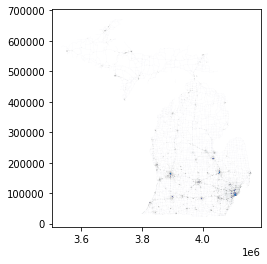

In [ ]:
gdf.plot()

In [ ]:
# Load City of Detroit Boundary
restURL = 'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdfDet = gisLayer.layerQuery()
#gdfDet.head()

Credentials Needed (YES/NO)? YES
ArcGIS Online USER ID: LocationArtistry
PASSWORD: ··········
set PROTOCOL to "https" from generate token


'MAPSERVER OBJECT CREATED'

<ArcServer: "services5.arcgis.com" ("UDWrEU6HdWNYIRIV")>

'0 - Service Name: 2019_Traffic_Volumes -  Service Type: FeatureServer'

'1 - Service Name: Building_Footprints -  Service Type: FeatureServer'

'2 - Service Name: Building_Footprints_semcog -  Service Type: FeatureServer'

'3 - Service Name: data -  Service Type: FeatureServer'

'4 - Service Name: Detroit -  Service Type: FeatureServer'

'5 - Service Name: detSchools100m -  Service Type: FeatureServer'

'6 - Service Name: detUAVzones -  Service Type: FeatureServer'

'7 - Service Name: FAA_UAS_FacilityMap_Data_V5 -  Service Type: FeatureServer'

'8 - Service Name: FULTON_SAMP_PARC -  Service Type: FeatureServer'

'9 - Service Name: NHBP_LANDS_2019 -  Service Type: FeatureServer'

'10 - Service Name: NHD_H_04050001_HU8_Shape -  Service Type: FeatureServer'

'11 - Service Name: SAMPLE_DESIGN -  Service Type: FeatureServer'

'12 - Service Name: Schools_All_Schools_2018_2019_shp -  Service Type: FeatureServer'

'13 - Service Name: service_6c3cc397d0f44f79a8c0bae463d73639 -  Service Type: FeatureServer'

'14 - Service Name: service_712be771664348a08642788e9e10e3e6 -  Service Type: FeatureServer'

'15 - Service Name: WATER_SAMPLING_2020 -  Service Type: FeatureServer'

'16 - Service Name: WATER_SAMPLING_2020_ee464df349124e9ea9635b0d4a9b47b5 -  Service Type: FeatureServer'

'17 - Service Name: WQ_HYDRO_SEP2019 -  Service Type: FeatureServer'

'18 - Service Name: ZOOM_EXTENTS -  Service Type: FeatureServer'

'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services -  '

Select index of subservice: 4


'ARCSERVICE OBJECT CREATED - https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/Detroit/FeatureServer'

'0 - Detroit_0'

Select index of Layer: 0


'LAYER CREATED - Detroit_0 - id: 0 - url: https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/Detroit/FeatureServer/0'

'Detroit_0 - capabilities: Query - query formats: JSON, geoJSON, PBF - count: 0'

SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


In [ ]:
gdfDet.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36230 entries, 0 to 36229
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Aadt      36230 non-null  int64   
 1   geometry  36230 non-null  geometry
dtypes: geometry(1), int64(1)
memory usage: 566.2 KB


In [ ]:
# Working to clip traffic count layers by Detroit Boundary
# Reproject Detroit boundary to MI State Plane South
gdfDet = gdf.to_crs(epsg=26990)

trafficClip = gpd.sjoin(gdfDet, gdf, op='intersects')

In [ ]:
#trafficClip = gpd.sjoin(gdf, gdfDet, op='intersects')
tcLeft = gdf.sjoin(gdfDet, how="left")

In [ ]:
tcLeft.head()

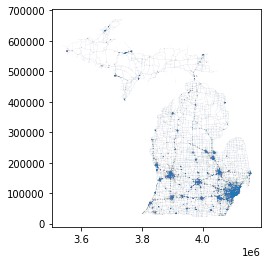

In [ ]:
tcLeft.plot()

In [ ]:
tcRight = gdf.sjoin(gdfDet, how="right")

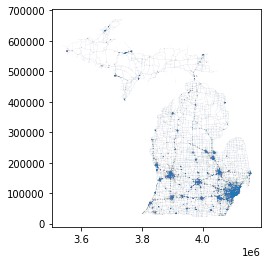

In [ ]:
tcRight.plot()

In [ ]:
clipTest = gdf.clip(gdfDet)

In [ ]:
overlay = gdfDet.overlay(gdf, how='intersection')

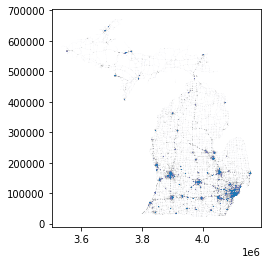

In [ ]:
overlay.plot()

In [ ]:
clip2 = gpd.clip(gdf, gdfDet)

In [ ]:
clip2 = gpd.clip(gdf, gdfDet)

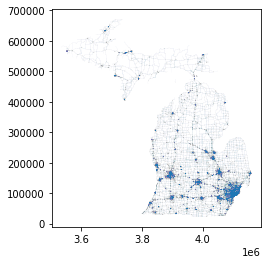

In [ ]:
trafficClip.plot()

In [ ]:
# reproject from WGS 84/EPSG=4326 to Michigan State Plane South - EPSG=26990
gdf = gdf.to_crs(epsg=26990)

# With units as meters, create a 500 m buffer around the schools
#gdfBuf = gdf.buffer(100)

# change out the original geometry for buffered polygons
# gdf['geometry'] = gdf.geometry.buffer(500)
# gdf.plot()

gdfBuf.to_file("detSchools100m.geojson", driver='GeoJSON')

filePath = os.path.join('/content', 'detSchools100m.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

### Unable to get any of the GeoPandas clipping operations to work.   
Each would return 180,000 features instead of only the features that remained within the Detroit boundary after the clip was performed, which should be significantly less than 36,000.  Layer 10m buffer created in notebook, published to AGOL, edited in ArcGIS Pro, clipped to city of Detroit Features, re-published to AGOL

In [ ]:
gis = agol()

ArcGIS Online USER ID: LocationArtistry
PASSWORD: ··········


'SUCCESS - CONNECTED TO: LocationArtistry ACCOUNT as <gis>'

GIS @ https://locationartistry.maps.arcgis.com version:9.3

In [ ]:
# ArcREST endpoint from our AGOL server
restURL = 'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services'
gisServer = mapServer(restURL)
# Select GIS service by number
gisService = gisServer.getSubService()
# Select layer from service
gisLayer = gisService.getLayer()
gisLayer.getInfo()
# query layer in generate GeoDataframe
gdf = gisLayer.layerQuery()
gdf.head()

# drop all columns except for 'Aadt'
gdf = gdf[['Aadt','geometry']]

# reproject from WGS 84/EPSG=4326 to Michigan State Plane South - EPSG=26990
gdf = gdf.to_crs(epsg=26990)

# change out the original geometry for buffered polygons
gdf['geometry'] = gdf.geometry.buffer(10)
# gdf.plot()

gdf.to_file("trafficBuffers.geojson", driver='GeoJSON')

filePath = os.path.join('/content', 'trafficBuffers.geojson')
gdfItem = gis.gis.content.add({'type':'GeoJson', 'overwrite':True}, filePath)
gdfItem.publish(file_type='GeoJson')

Credentials Needed (YES/NO)? YES
ArcGIS Online USER ID: LocationArtistry
PASSWORD: ··········
set PROTOCOL to "https" from generate token


'MAPSERVER OBJECT CREATED'

<ArcServer: "services5.arcgis.com" ("UDWrEU6HdWNYIRIV")>

'0 - Service Name: 2019_Traffic_Volumes -  Service Type: FeatureServer'

'1 - Service Name: Building_Footprints -  Service Type: FeatureServer'

'2 - Service Name: Building_Footprints_semcog -  Service Type: FeatureServer'

'3 - Service Name: data -  Service Type: FeatureServer'

'4 - Service Name: Detroit -  Service Type: FeatureServer'

'5 - Service Name: detSchools100m -  Service Type: FeatureServer'

'6 - Service Name: detUAVzones -  Service Type: FeatureServer'

'7 - Service Name: FAA_UAS_FacilityMap_Data_V5 -  Service Type: FeatureServer'

'8 - Service Name: FULTON_SAMP_PARC -  Service Type: FeatureServer'

'9 - Service Name: NHBP_LANDS_2019 -  Service Type: FeatureServer'

'10 - Service Name: NHD_H_04050001_HU8_Shape -  Service Type: FeatureServer'

'11 - Service Name: SAMPLE_DESIGN -  Service Type: FeatureServer'

'12 - Service Name: Schools_All_Schools_2018_2019_shp -  Service Type: FeatureServer'

'13 - Service Name: service_6c3cc397d0f44f79a8c0bae463d73639 -  Service Type: FeatureServer'

'14 - Service Name: service_712be771664348a08642788e9e10e3e6 -  Service Type: FeatureServer'

'15 - Service Name: WATER_SAMPLING_2020 -  Service Type: FeatureServer'

'16 - Service Name: WATER_SAMPLING_2020_ee464df349124e9ea9635b0d4a9b47b5 -  Service Type: FeatureServer'

'17 - Service Name: WQ_HYDRO_SEP2019 -  Service Type: FeatureServer'

'18 - Service Name: ZOOM_EXTENTS -  Service Type: FeatureServer'

'https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services -  '

Select index of subservice: 0


'ARCSERVICE OBJECT CREATED - https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/2019_Traffic_Volumes/FeatureServer'

'0 - 2019_Traffic_Volumes'

Select index of Layer: 0


'LAYER CREATED - 2019_Traffic_Volumes - id: 0 - url: https://services5.arcgis.com/UDWrEU6HdWNYIRIV/arcgis/rest/services/2019_Traffic_Volumes/FeatureServer/0'

'2019_Traffic_Volumes - capabilities: Query,Extract - query formats: JSON, geoJSON, PBF - count: 0'

SQL query(ENTER for ALL): 
Fields(ENTER for ALL)? 


<Item title:"trafficBuffers" type:Feature Layer Collection owner:LocationArtistry>